# World Cup Event Plots

Visualizing GDP levels and YoY growth around World Cup events:
- **Winners**: Countries that won the World Cup (±16 quarters around the win)
- **Hosts**: Countries that hosted the World Cup (±16 quarters around the event)

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

pd.set_option('display.max_columns', None)

# Create output folder
OUTPUT_DIR = 'event descriptive plots'
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Plots will be saved to: {OUTPUT_DIR}/")

Plots will be saved to: event descriptive plots/


In [12]:
# Load data
df = pd.read_csv('paper_replication_event_study_sample.csv')

# Column names for GDP (used in existing plots)
gdp_col = 'gross_domestic_product_chain_linked_volume_rebased_us_dollars_ppp_converted'
yoy_col = f'{gdp_col}_yoy_pct'

# All features to plot (level column, yoy column, display name)
FEATURES = [
    ('gross_domestic_product_chain_linked_volume_rebased_us_dollars_ppp_converted', 'GDP'),
    ('final_consumption_expenditure_chain_linked_volume_rebased_us_dollars_ppp_converted', 'Consumption'),
    ('gross_fixed_capital_formation_chain_linked_volume_rebased_us_dollars_ppp_converted', 'Investment'),
    ('exports_of_goods_and_services_chain_linked_volume_rebased_us_dollars_ppp_converted', 'Exports'),
    ('imports_of_goods_and_services_chain_linked_volume_rebased_us_dollars_ppp_converted', 'Imports'),
]

# Create time index
df['tq'] = df['year'] * 4 + df['qtr']
df = df.sort_values(['country', 'tq'])

print(f"Loaded {len(df):,} rows, {df['country'].nunique()} countries")
print(f"\nFeatures to plot: {[f[1] for f in FEATURES]}")

Loaded 8,737 rows, 48 countries

Features to plot: ['GDP', 'Consumption', 'Investment', 'Exports', 'Imports']


## Define World Cup Events

In [13]:
# World Cup winners (country, year, event quarter = Q2)
winners = [
    ('GBR', 1966, 'England 1966'),
    ('DEU', 1974, 'Germany 1974'),
    ('ARG', 1978, 'Argentina 1978'),
    ('ITA', 1982, 'Italy 1982'),
    ('ARG', 1986, 'Argentina 1986'),
    ('DEU', 1990, 'Germany 1990'),
    ('BRA', 1994, 'Brazil 1994'),
    ('FRA', 1998, 'France 1998'),
    ('BRA', 2002, 'Brazil 2002'),
    ('ITA', 2006, 'Italy 2006'),
    ('ESP', 2010, 'Spain 2010'),
    ('DEU', 2014, 'Germany 2014'),
    ('FRA', 2018, 'France 2018'),
]

# World Cup hosts
hosts = [
    ('GBR', 1966, 'England 1966'),
    ('MEX', 1970, 'Mexico 1970'),
    ('DEU', 1974, 'Germany 1974'),
    ('ARG', 1978, 'Argentina 1978'),
    ('ESP', 1982, 'Spain 1982'),
    ('MEX', 1986, 'Mexico 1986'),
    ('ITA', 1990, 'Italy 1990'),
    ('USA', 1994, 'USA 1994'),
    ('FRA', 1998, 'France 1998'),
    ('JPN', 2002, 'Japan 2002'),
    ('KOR', 2002, 'Korea 2002'),
    ('DEU', 2006, 'Germany 2006'),
    ('ZAF', 2010, 'South Africa 2010'),
    ('BRA', 2014, 'Brazil 2014'),
    ('RUS', 2018, 'Russia 2018'),
]

print(f"Winners: {len(winners)} events")
print(f"Hosts: {len(hosts)} events")

Winners: 13 events
Hosts: 15 events


## Plotting Function

In [14]:
def plot_event(df, country, year, title, gdp_col, yoy_col, window=16, save_path=None):
    """
    Plot GDP level and YoY growth around an event.
    
    Parameters:
    - country: ISO3 country code
    - year: World Cup year
    - title: Plot title
    - window: quarters before/after event (default ±16)
    - save_path: if provided, save figure to this path
    """
    # Event quarter (Q2 of WC year)
    event_tq = year * 4 + 2
    
    # Filter country data
    country_df = df[df['country'] == country].copy()
    
    if len(country_df) == 0:
        print(f"No data for {country}")
        return None
    
    # Calculate relative time
    country_df['rel_time'] = country_df['tq'] - event_tq
    
    # Filter to window
    plot_df = country_df[(country_df['rel_time'] >= -window) & (country_df['rel_time'] <= window)].copy()
    
    if len(plot_df) < 5:
        print(f"Insufficient data for {title}")
        return None
    
    # Create figure with dual y-axis
    fig, ax1 = plt.subplots(figsize=(12, 5))
    
    # GDP level (left axis) - scale to billions
    gdp_billions = plot_df[gdp_col] / 1e6  # Convert to billions
    color1 = 'steelblue'
    ax1.plot(plot_df['rel_time'], gdp_billions, 'o-', color=color1, linewidth=2, markersize=4, label='GDP Level')
    ax1.set_xlabel('Quarters relative to World Cup (q=0 at Q2)', fontsize=11)
    ax1.set_ylabel('GDP (billions USD PPP)', color=color1, fontsize=11)
    ax1.tick_params(axis='y', labelcolor=color1)
    
    # YoY growth (right axis)
    ax2 = ax1.twinx()
    color2 = 'coral'
    ax2.plot(plot_df['rel_time'], plot_df[yoy_col], 's--', color=color2, linewidth=2, markersize=4, label='YoY Growth')
    ax2.set_ylabel('YoY GDP Growth (%)', color=color2, fontsize=11)
    ax2.tick_params(axis='y', labelcolor=color2)
    ax2.axhline(0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
    
    # World Cup marker (dashed vertical line at q=0)
    ax1.axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='World Cup')
    
    # Shade post-treatment region
    ax1.axvspan(0, window, alpha=0.05, color='red')
    
    # Title and legend
    ax1.set_title(f'{title}', fontsize=14, fontweight='bold')
    ax1.set_xticks(range(-window, window+1, 4))
    ax1.grid(True, alpha=0.3)
    
    # Combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        fig.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    return fig

## World Cup Winners

WORLD CUP WINNERS: GDP and YoY Growth (±16 quarters)


Saved: event descriptive plots\winner_GBR_1966.png


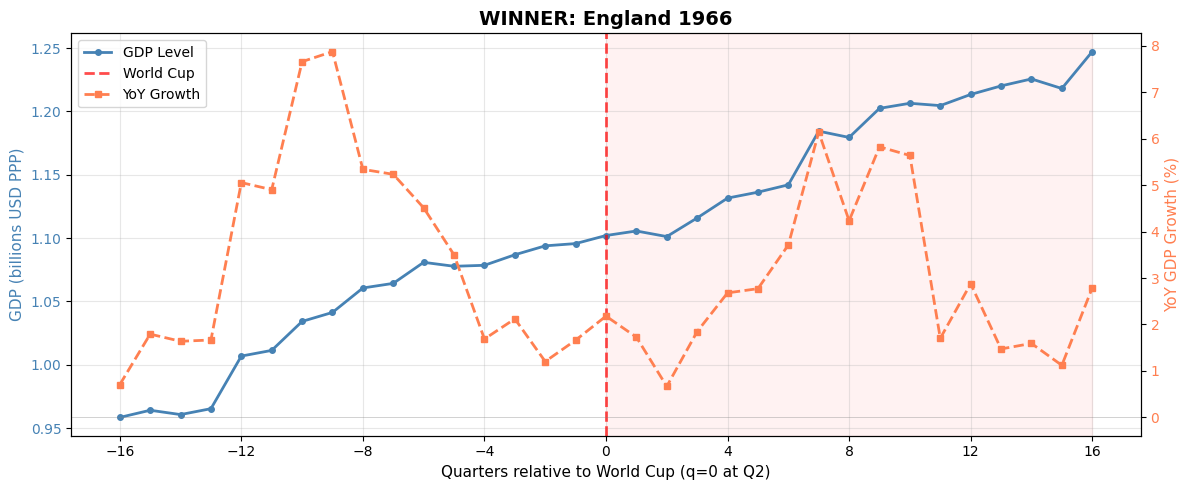


Saved: event descriptive plots\winner_DEU_1974.png


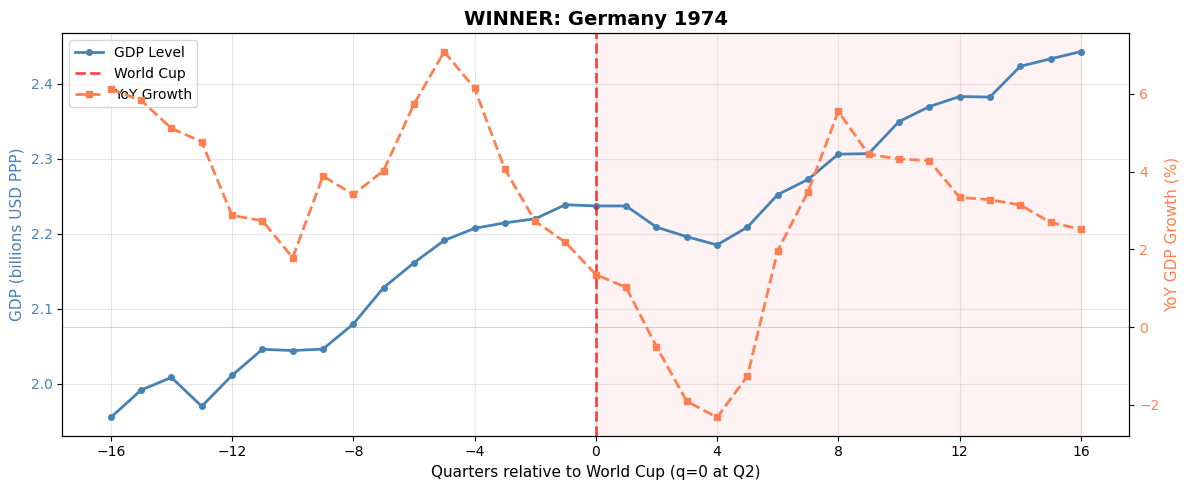


Insufficient data for WINNER: Argentina 1978

Saved: event descriptive plots\winner_ITA_1982.png


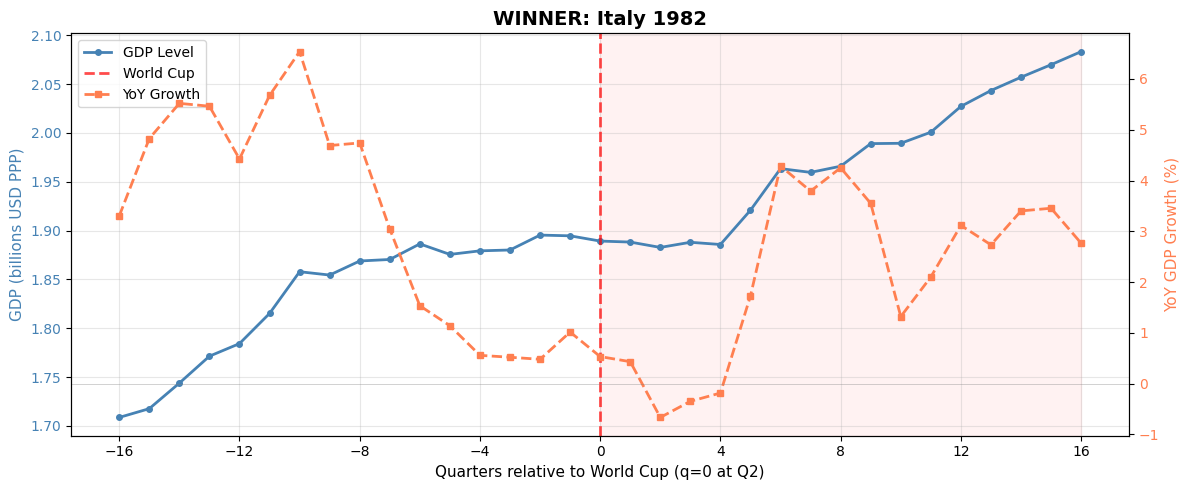


Insufficient data for WINNER: Argentina 1986

Saved: event descriptive plots\winner_DEU_1990.png


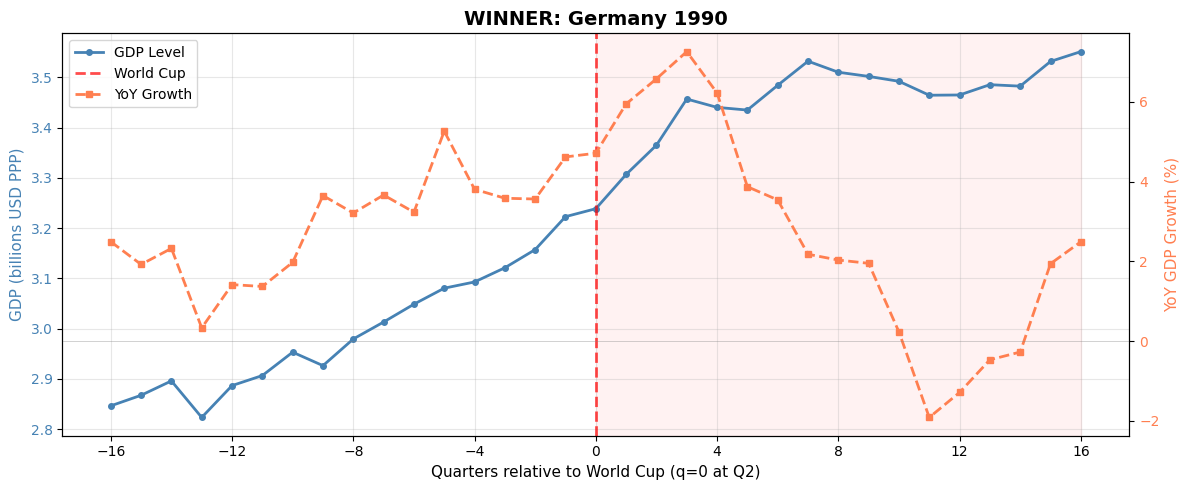


Insufficient data for WINNER: Brazil 1994

Saved: event descriptive plots\winner_FRA_1998.png


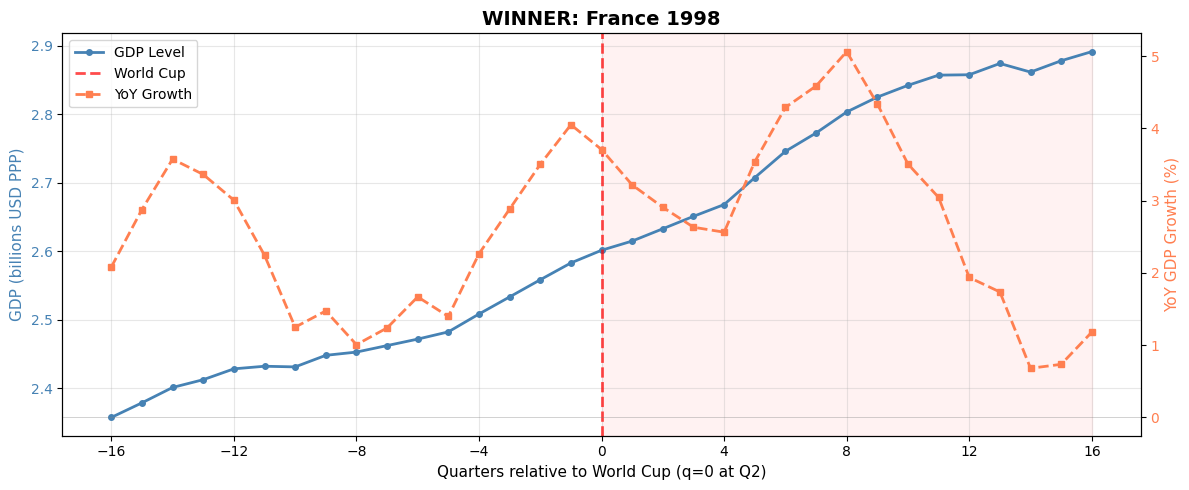


Saved: event descriptive plots\winner_BRA_2002.png


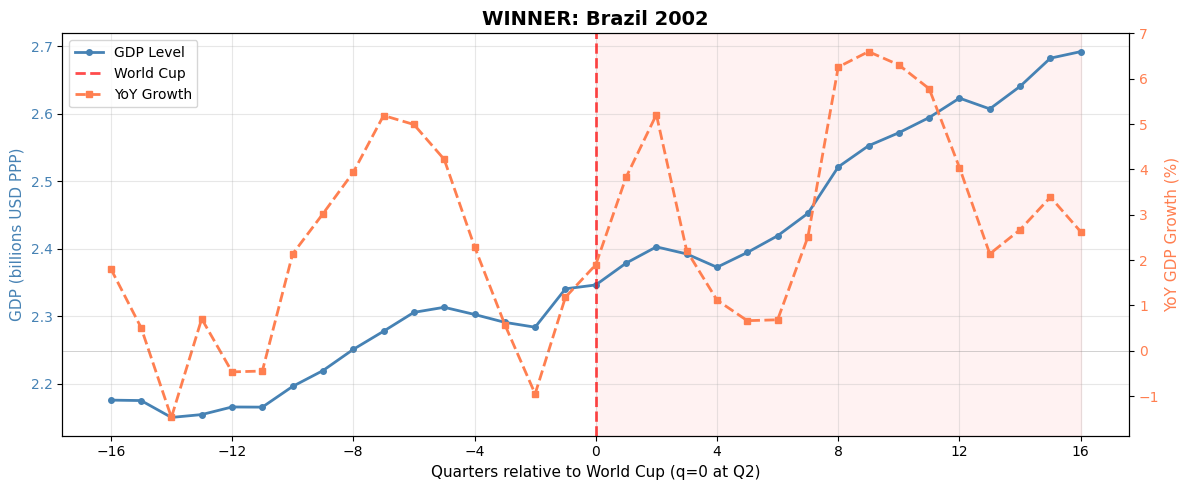


Saved: event descriptive plots\winner_ITA_2006.png


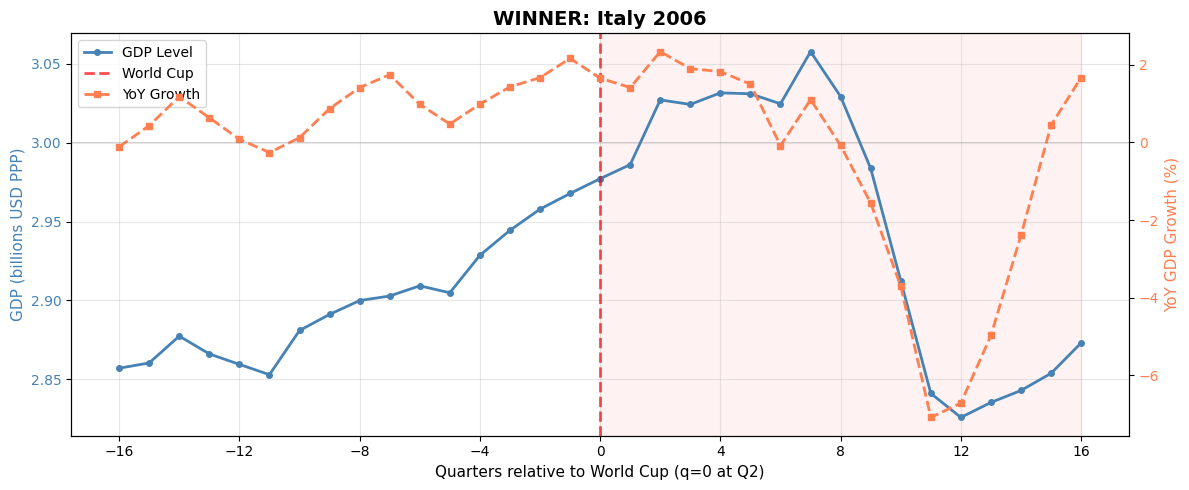


Saved: event descriptive plots\winner_ESP_2010.png


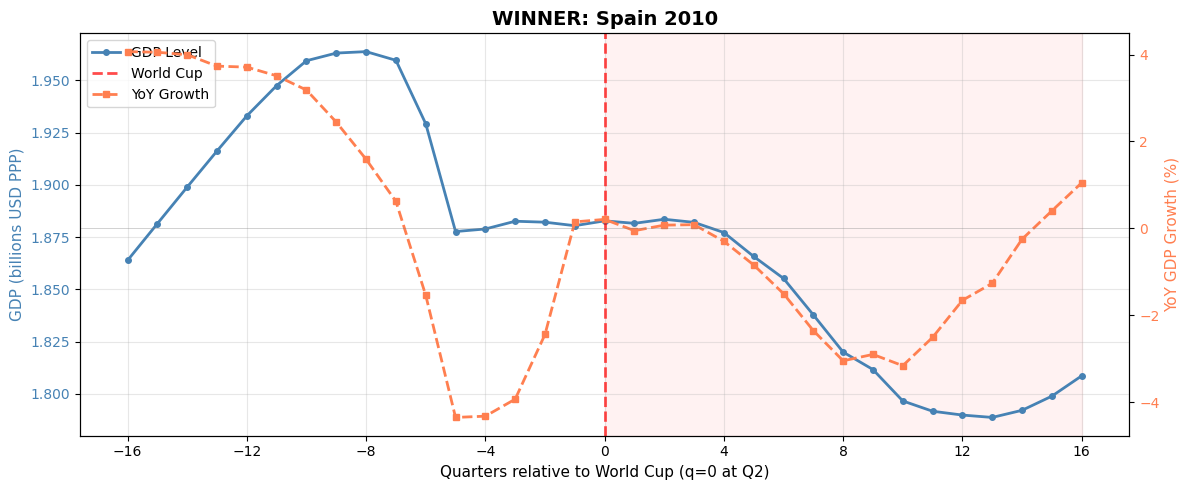


Saved: event descriptive plots\winner_DEU_2014.png


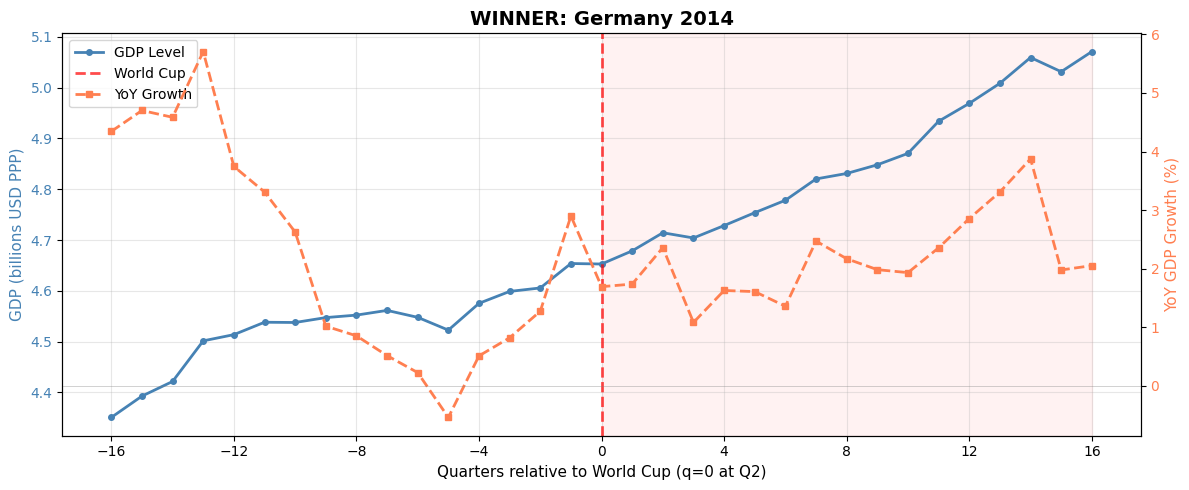


Saved: event descriptive plots\winner_FRA_2018.png


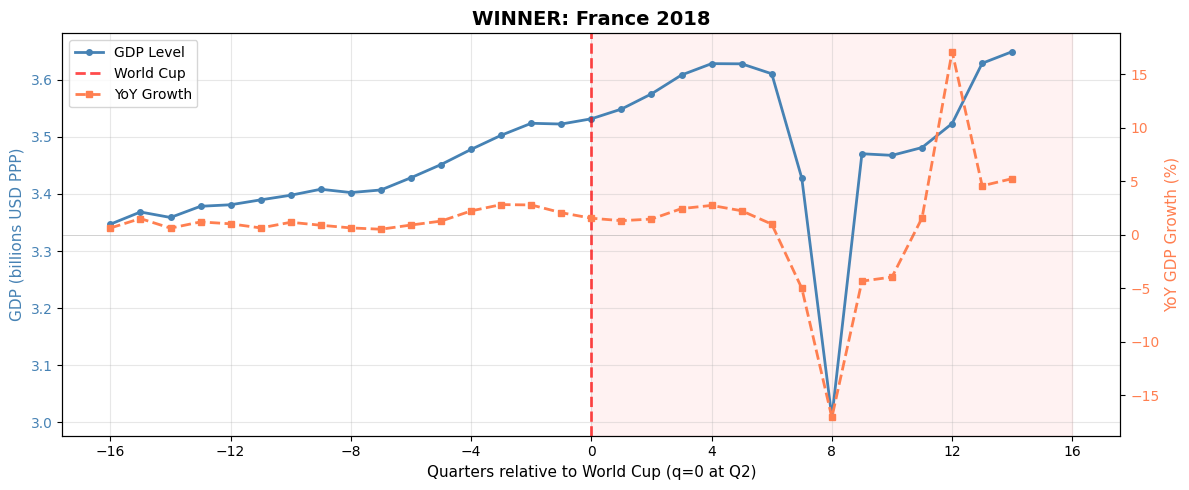

In [15]:
# Plot each World Cup winner
print("=" * 60)
print("WORLD CUP WINNERS: GDP and YoY Growth (±16 quarters)")
print("=" * 60)

for country, year, title in winners:
    filename = f"winner_{country}_{year}.png"
    save_path = os.path.join(OUTPUT_DIR, filename)
    fig = plot_event(df, country, year, f"WINNER: {title}", gdp_col, yoy_col, save_path=save_path)
    if fig:
        plt.show()
        plt.close(fig)
    print()

## World Cup Hosts

WORLD CUP HOSTS: GDP and YoY Growth (±16 quarters)
Saved: event descriptive plots\host_GBR_1966.png


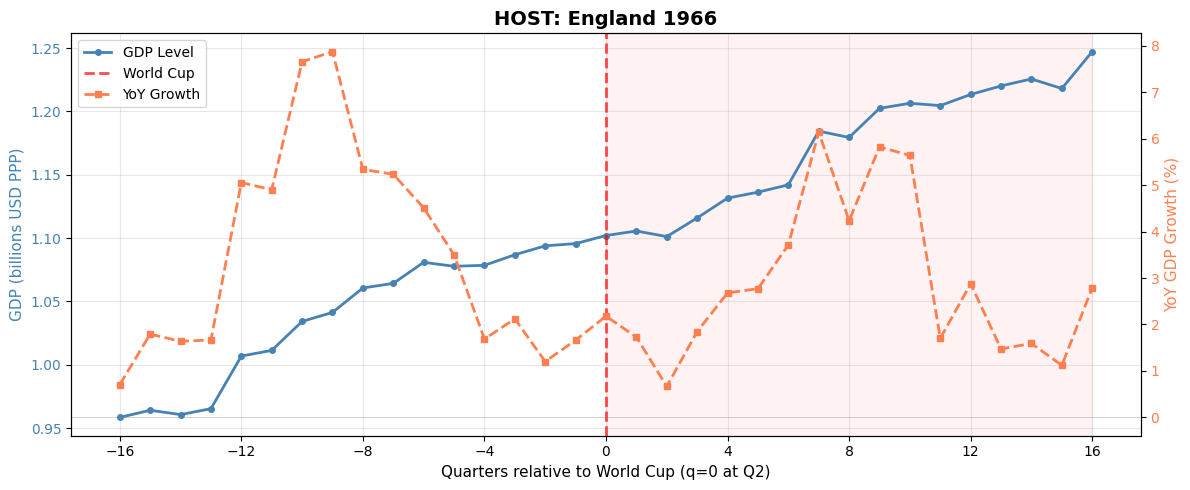


Saved: event descriptive plots\host_MEX_1970.png


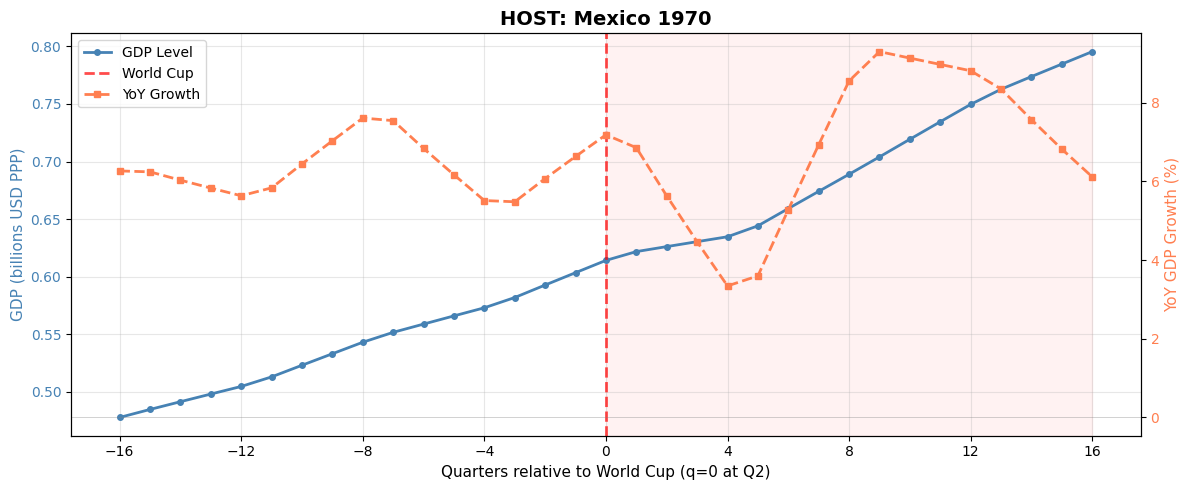


Saved: event descriptive plots\host_DEU_1974.png


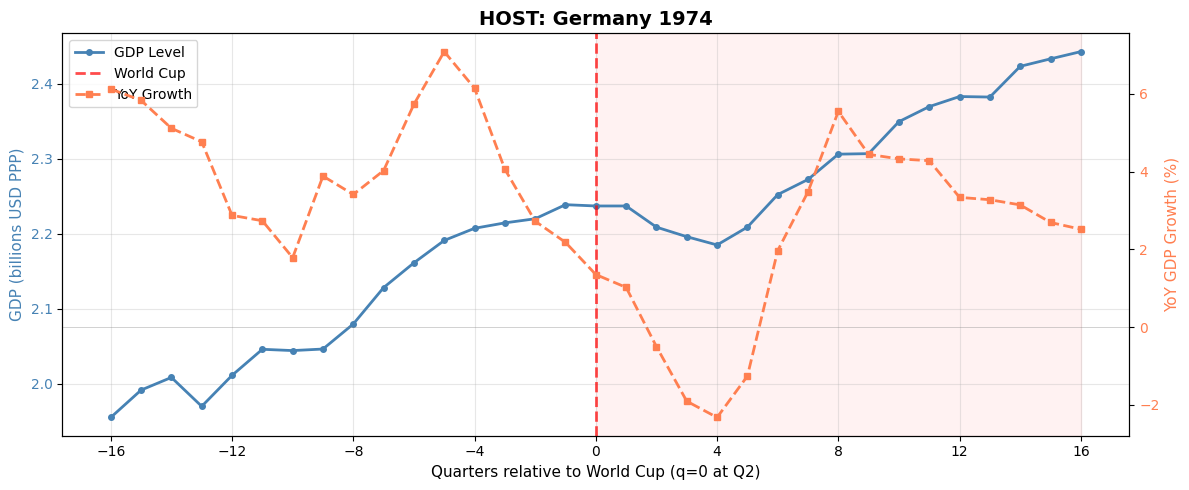


Insufficient data for HOST: Argentina 1978

Saved: event descriptive plots\host_ESP_1982.png


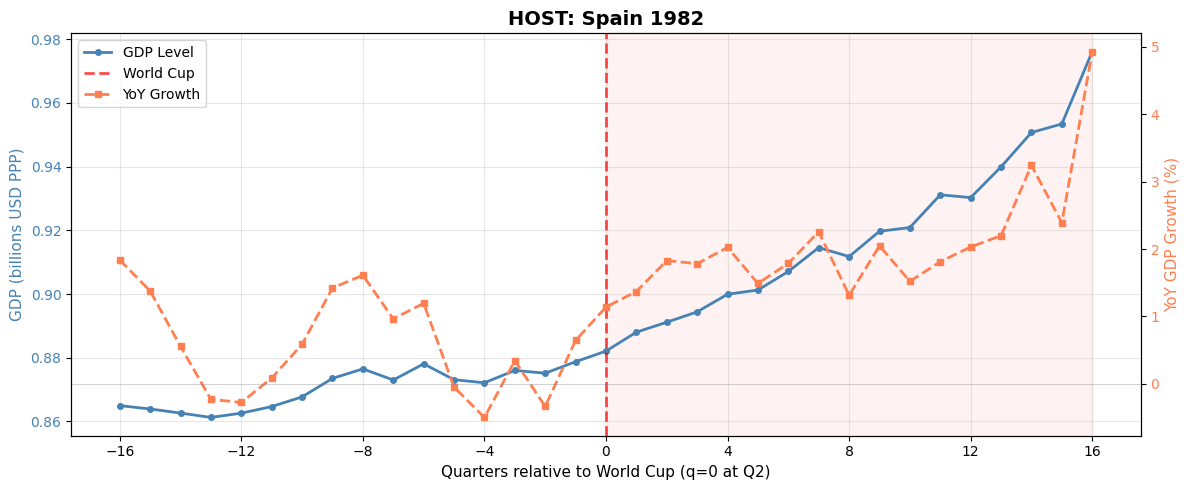


Saved: event descriptive plots\host_MEX_1986.png


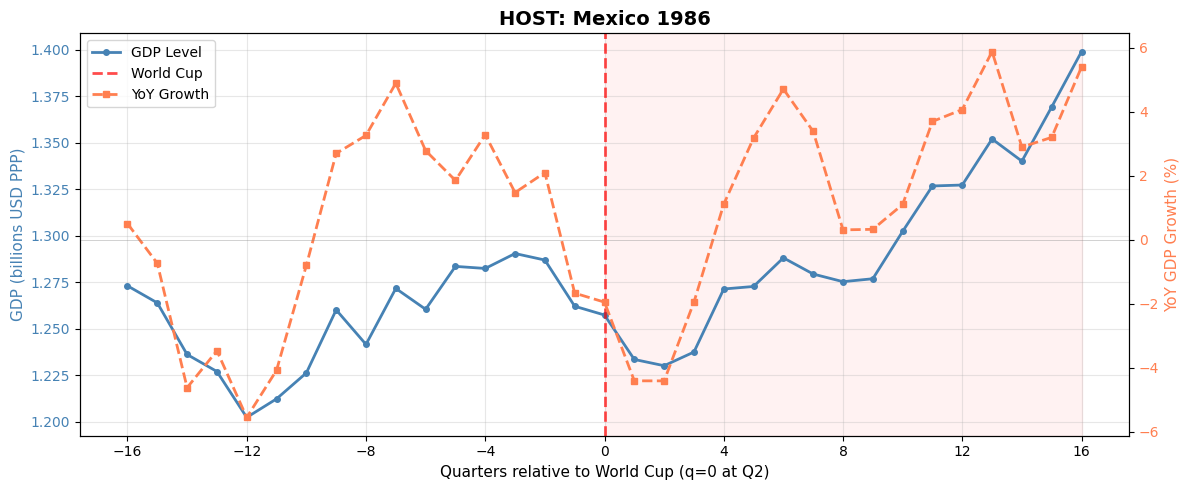


Saved: event descriptive plots\host_ITA_1990.png


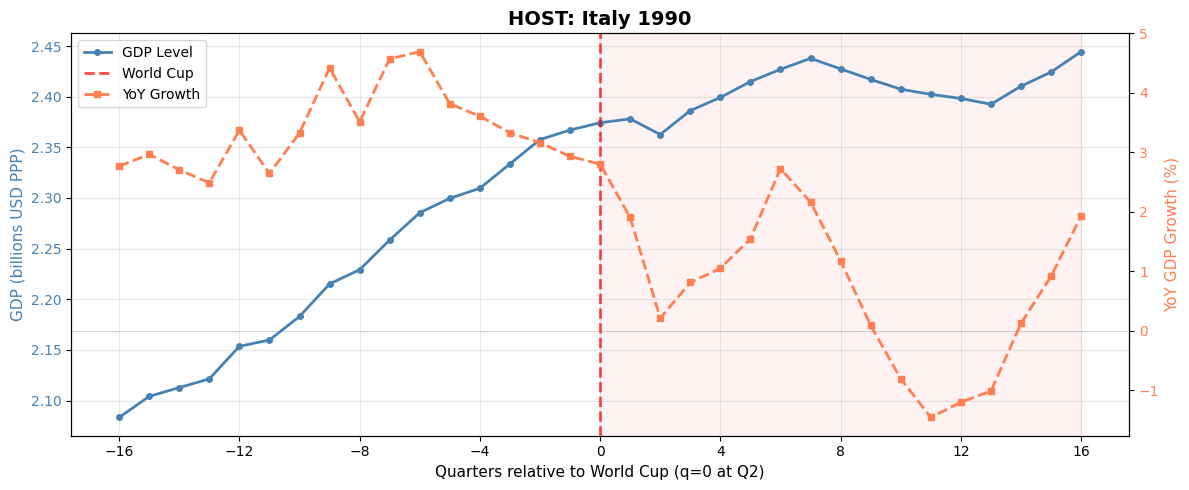


Saved: event descriptive plots\host_USA_1994.png


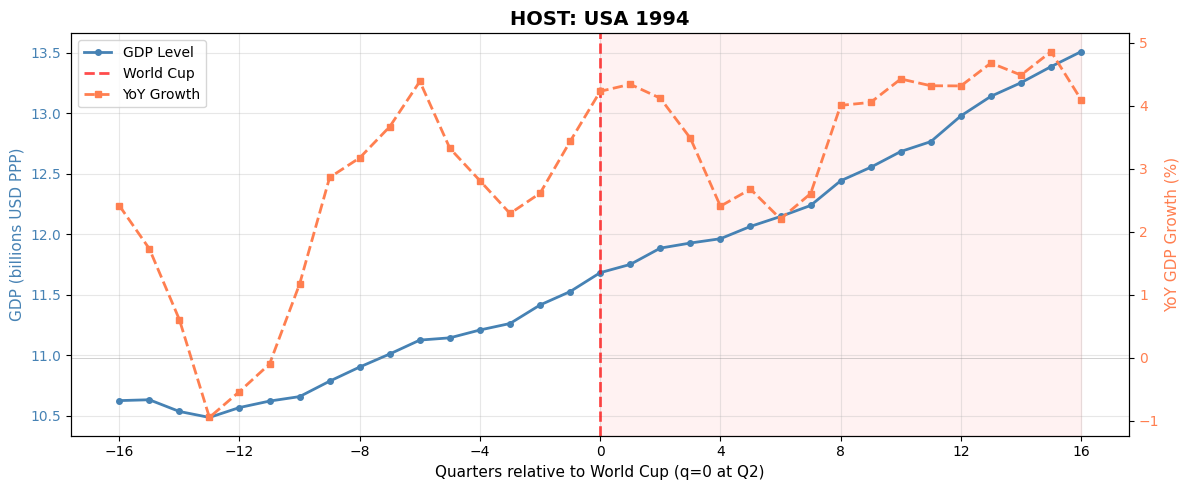


Saved: event descriptive plots\host_FRA_1998.png


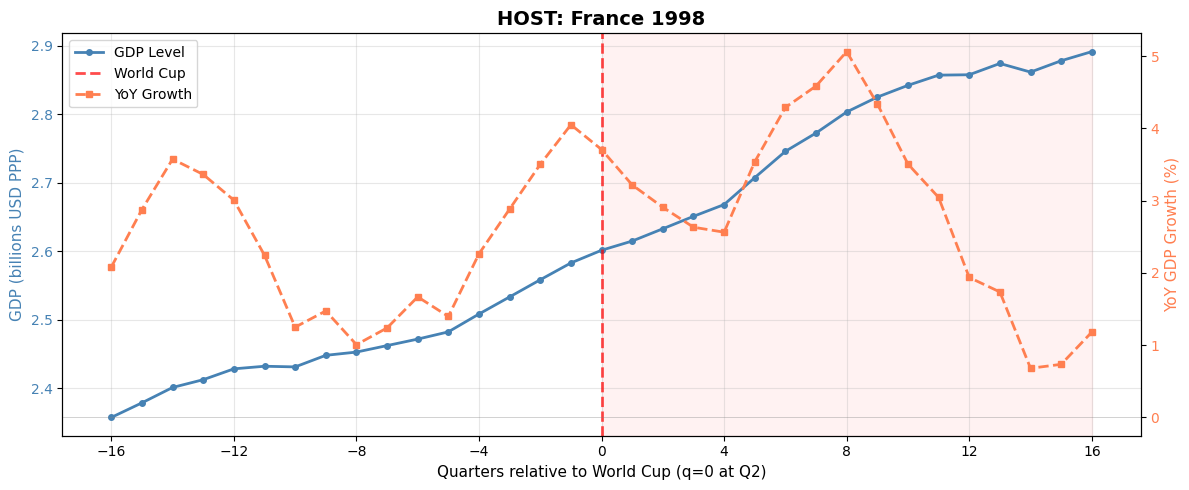


Saved: event descriptive plots\host_JPN_2002.png


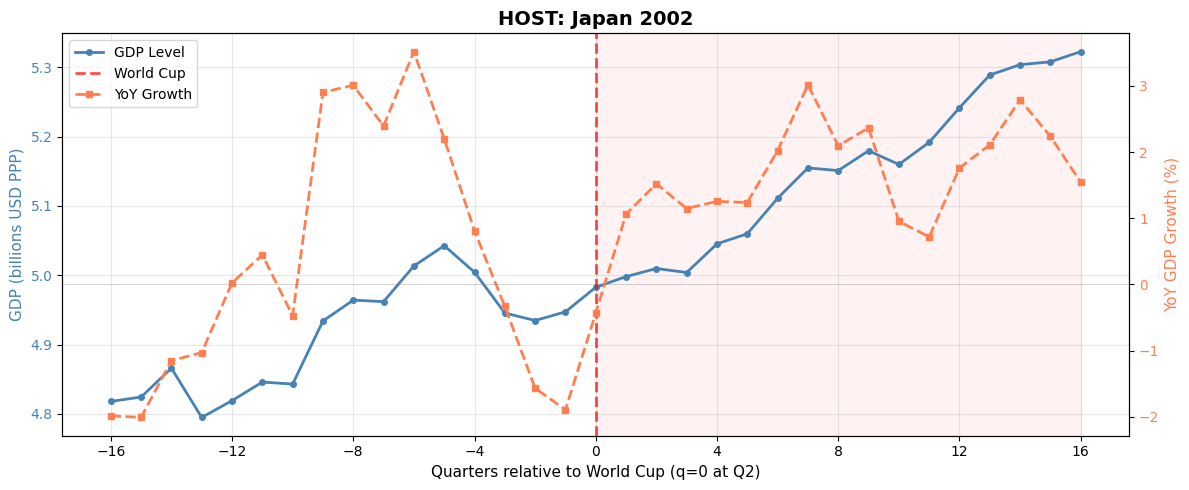


Saved: event descriptive plots\host_KOR_2002.png


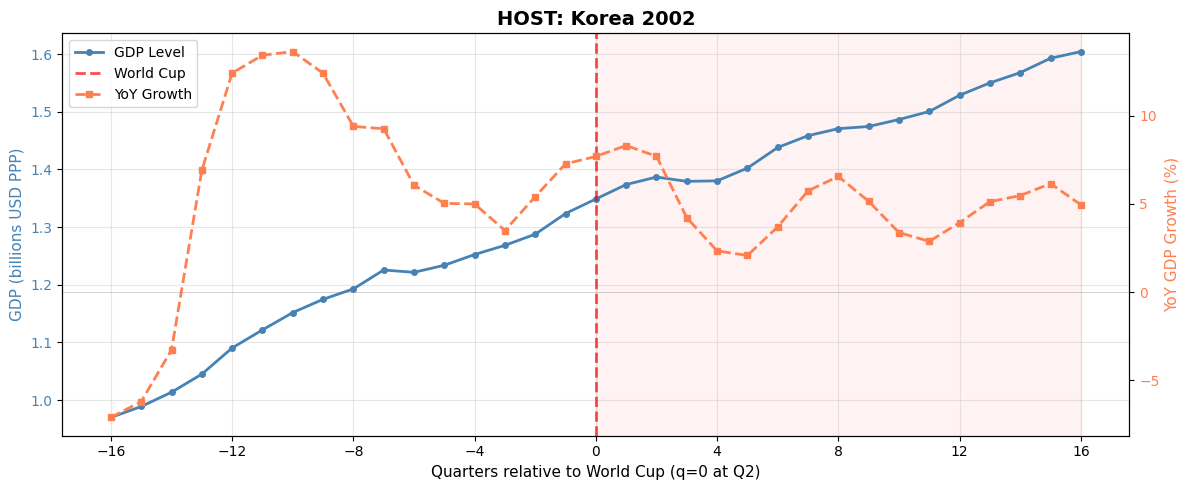


Saved: event descriptive plots\host_DEU_2006.png


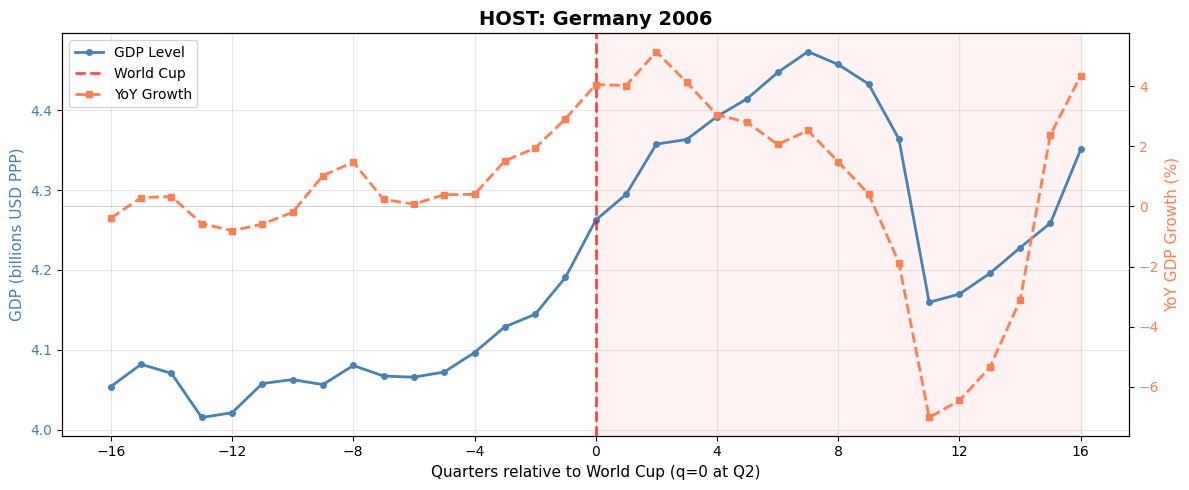


Saved: event descriptive plots\host_ZAF_2010.png


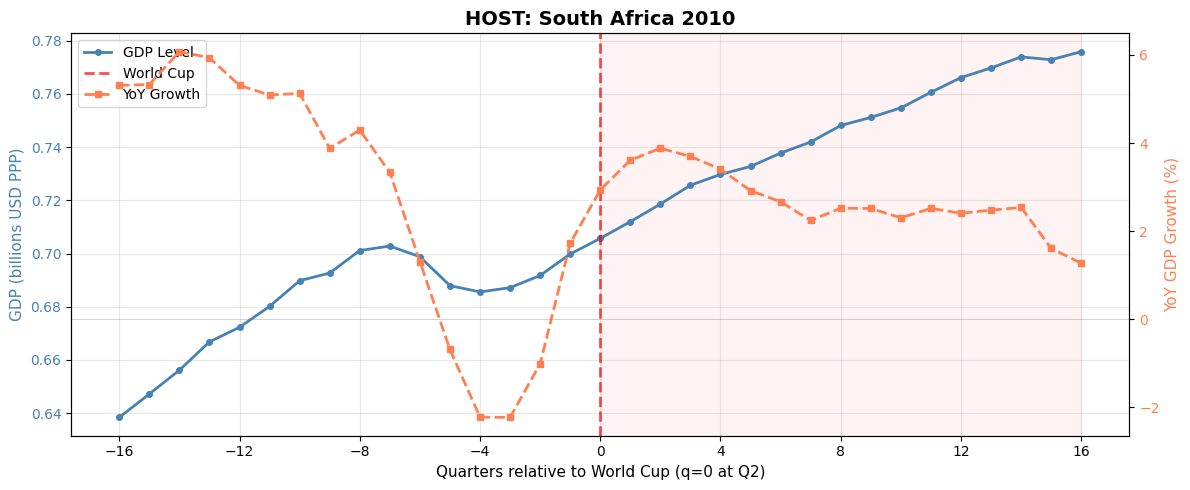


Saved: event descriptive plots\host_BRA_2014.png


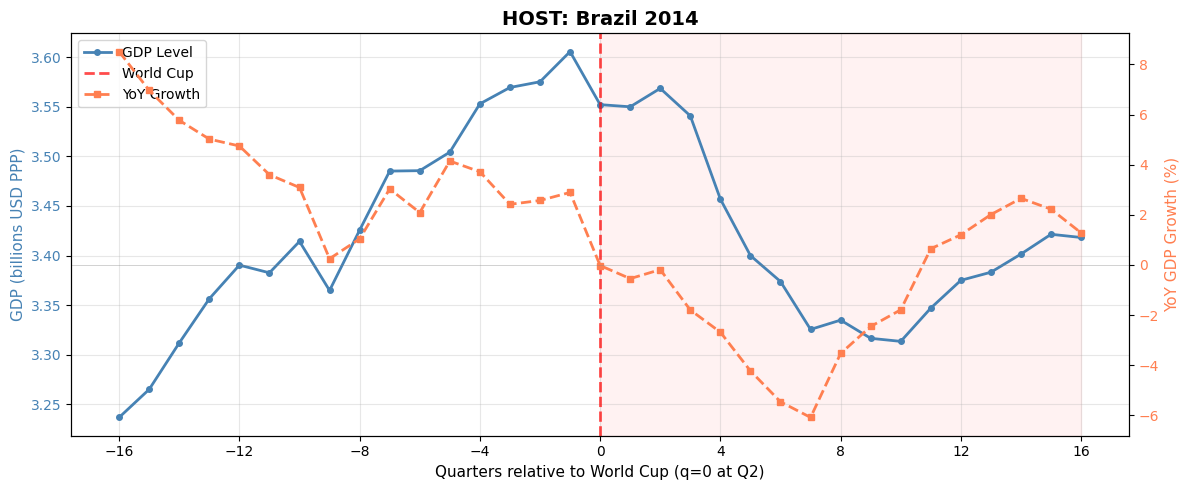


Saved: event descriptive plots\host_RUS_2018.png


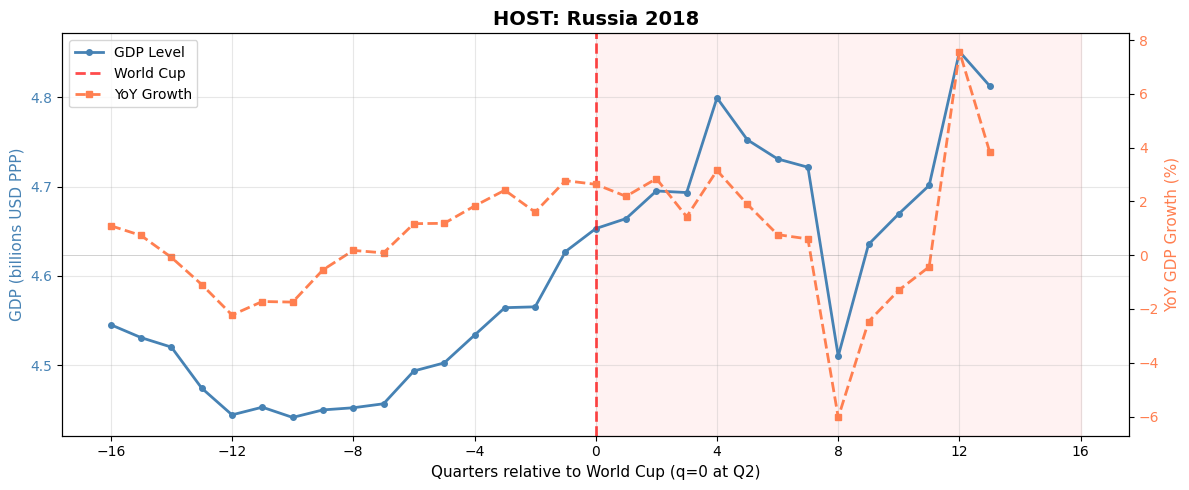

In [16]:
# Plot each World Cup host
print("=" * 60)
print("WORLD CUP HOSTS: GDP and YoY Growth (±16 quarters)")
print("=" * 60)

for country, year, title in hosts:
    filename = f"host_{country}_{year}.png"
    save_path = os.path.join(OUTPUT_DIR, filename)
    fig = plot_event(df, country, year, f"HOST: {title}", gdp_col, yoy_col, save_path=save_path)
    if fig:
        plt.show()
        plt.close(fig)
    print()

## Summary: Average Patterns

In [17]:
# Compute average YoY growth pattern across all winners and hosts

def extract_event_series(df, events, gdp_col, yoy_col, window=16):
    """Extract normalized series for each event."""
    all_series = []
    
    for country, year, title in events:
        event_tq = year * 4 + 2
        country_df = df[df['country'] == country].copy()
        
        if len(country_df) == 0:
            continue
            
        country_df['rel_time'] = country_df['tq'] - event_tq
        event_df = country_df[(country_df['rel_time'] >= -window) & (country_df['rel_time'] <= window)].copy()
        
        if len(event_df) < 20:
            continue
            
        event_df['event_label'] = title
        all_series.append(event_df[['rel_time', yoy_col, gdp_col, 'event_label']])
    
    if all_series:
        return pd.concat(all_series, ignore_index=True)
    return pd.DataFrame()

# Extract series
winners_df = extract_event_series(df, winners, gdp_col, yoy_col)
hosts_df = extract_event_series(df, hosts, gdp_col, yoy_col)

print(f"Winner events with full data: {winners_df['event_label'].nunique()}")
print(f"Host events with full data: {hosts_df['event_label'].nunique()}")

Winner events with full data: 10
Host events with full data: 14


Saved: event descriptive plots/summary_avg_winners_vs_hosts.png


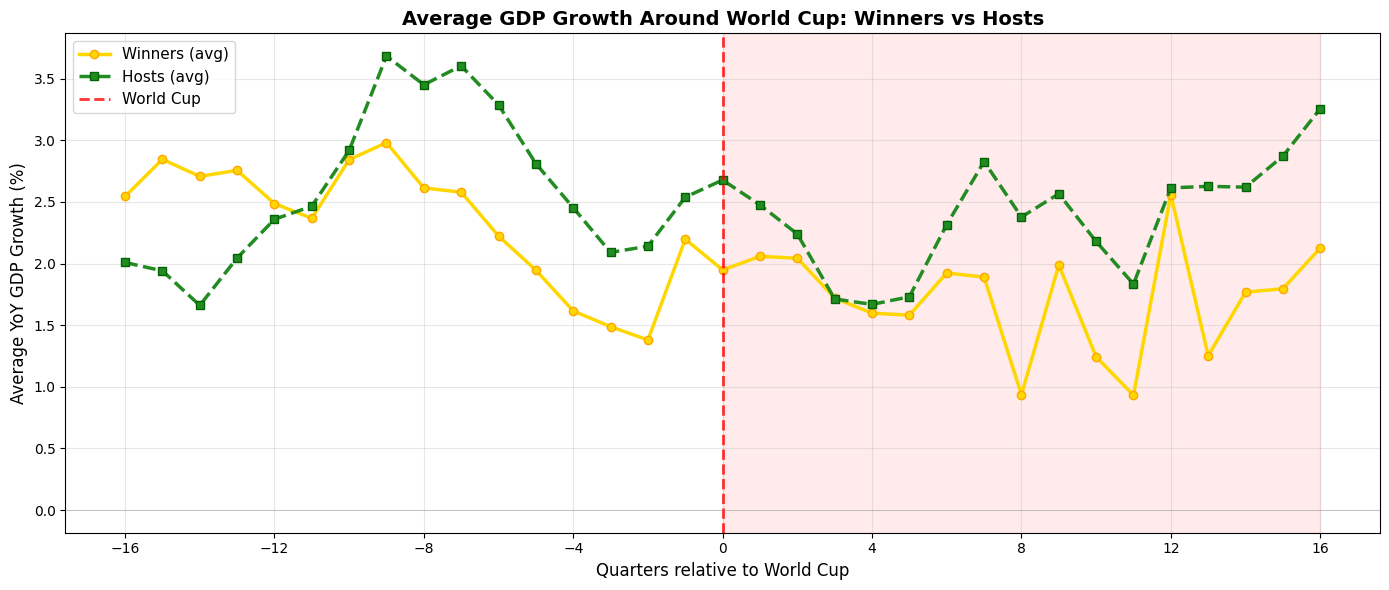

In [18]:
# Average YoY growth by relative time: Winners vs Hosts

fig, ax = plt.subplots(figsize=(14, 6))

# Winners average
if len(winners_df) > 0:
    winners_avg = winners_df.groupby('rel_time')[yoy_col].mean()
    ax.plot(winners_avg.index, winners_avg.values, 'o-', color='gold', linewidth=2.5, 
            markersize=6, label='Winners (avg)', markeredgecolor='orange')

# Hosts average
if len(hosts_df) > 0:
    hosts_avg = hosts_df.groupby('rel_time')[yoy_col].mean()
    ax.plot(hosts_avg.index, hosts_avg.values, 's--', color='forestgreen', linewidth=2.5, 
            markersize=6, label='Hosts (avg)', markeredgecolor='darkgreen')

# World Cup marker
ax.axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.8, label='World Cup')
ax.axhline(0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)

# Shade post-event
ax.axvspan(0, 16, alpha=0.08, color='red')

ax.set_xlabel('Quarters relative to World Cup', fontsize=12)
ax.set_ylabel('Average YoY GDP Growth (%)', fontsize=12)
ax.set_title('Average GDP Growth Around World Cup: Winners vs Hosts', fontsize=14, fontweight='bold')
ax.set_xticks(range(-16, 17, 4))
ax.legend(loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
fig.savefig(os.path.join(OUTPUT_DIR, 'summary_avg_winners_vs_hosts.png'), dpi=150, bbox_inches='tight')
print(f"Saved: {OUTPUT_DIR}/summary_avg_winners_vs_hosts.png")
plt.show()
plt.close(fig)

Saved: event descriptive plots/summary_all_winners_overlay.png


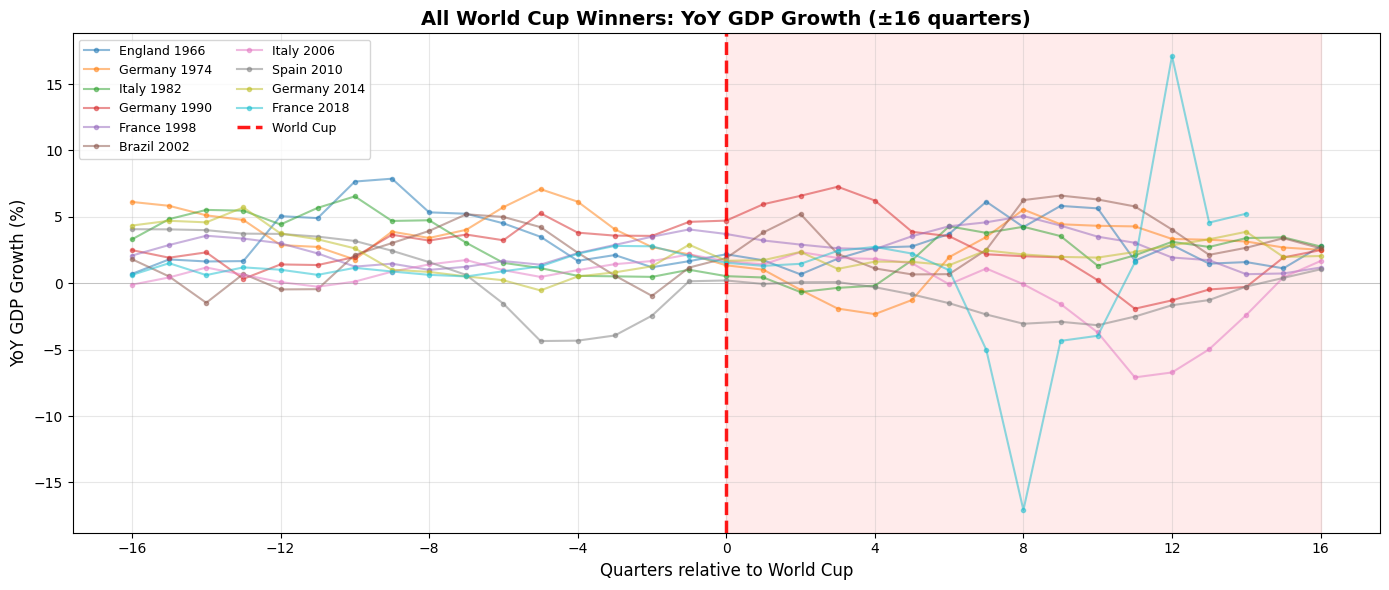

In [19]:
# All winner events overlaid (YoY growth)

fig, ax = plt.subplots(figsize=(14, 6))

# Plot each winner event
for event_label in winners_df['event_label'].unique():
    event_data = winners_df[winners_df['event_label'] == event_label]
    ax.plot(event_data['rel_time'], event_data[yoy_col], 'o-', alpha=0.5, linewidth=1.5, 
            markersize=3, label=event_label)

# World Cup marker
ax.axvline(0, color='red', linestyle='--', linewidth=2.5, alpha=0.9, label='World Cup')
ax.axhline(0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
ax.axvspan(0, 16, alpha=0.08, color='red')

ax.set_xlabel('Quarters relative to World Cup', fontsize=12)
ax.set_ylabel('YoY GDP Growth (%)', fontsize=12)
ax.set_title('All World Cup Winners: YoY GDP Growth (±16 quarters)', fontsize=14, fontweight='bold')
ax.set_xticks(range(-16, 17, 4))
ax.legend(loc='upper left', fontsize=9, ncol=2)
ax.grid(True, alpha=0.3)

plt.tight_layout()
fig.savefig(os.path.join(OUTPUT_DIR, 'summary_all_winners_overlay.png'), dpi=150, bbox_inches='tight')
print(f"Saved: {OUTPUT_DIR}/summary_all_winners_overlay.png")
plt.show()
plt.close(fig)

Saved: event descriptive plots/summary_all_hosts_overlay.png


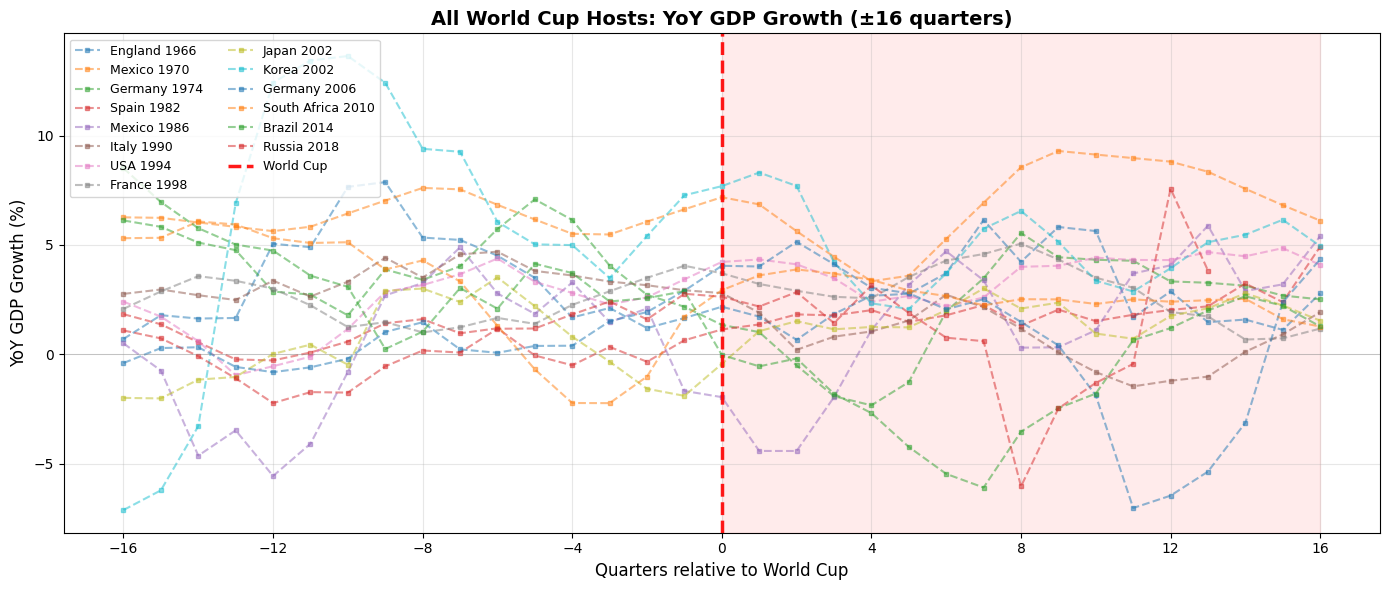

In [20]:
# All host events overlaid (YoY growth)

fig, ax = plt.subplots(figsize=(14, 6))

# Plot each host event
for event_label in hosts_df['event_label'].unique():
    event_data = hosts_df[hosts_df['event_label'] == event_label]
    ax.plot(event_data['rel_time'], event_data[yoy_col], 's--', alpha=0.5, linewidth=1.5, 
            markersize=3, label=event_label)

# World Cup marker
ax.axvline(0, color='red', linestyle='--', linewidth=2.5, alpha=0.9, label='World Cup')
ax.axhline(0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
ax.axvspan(0, 16, alpha=0.08, color='red')

ax.set_xlabel('Quarters relative to World Cup', fontsize=12)
ax.set_ylabel('YoY GDP Growth (%)', fontsize=12)
ax.set_title('All World Cup Hosts: YoY GDP Growth (±16 quarters)', fontsize=14, fontweight='bold')
ax.set_xticks(range(-16, 17, 4))
ax.legend(loc='upper left', fontsize=9, ncol=2)
ax.grid(True, alpha=0.3)

plt.tight_layout()
fig.savefig(os.path.join(OUTPUT_DIR, 'summary_all_hosts_overlay.png'), dpi=150, bbox_inches='tight')
print(f"Saved: {OUTPUT_DIR}/summary_all_hosts_overlay.png")
plt.show()
plt.close(fig)

## Winners: All Macroeconomic Features

Plots for Consumption, Investment, Exports, and Imports (in addition to GDP above).

WORLD CUP WINNERS: CONSUMPTION (±16 quarters)
Saved: event descriptive plots\winner_consumption_GBR_1966.png


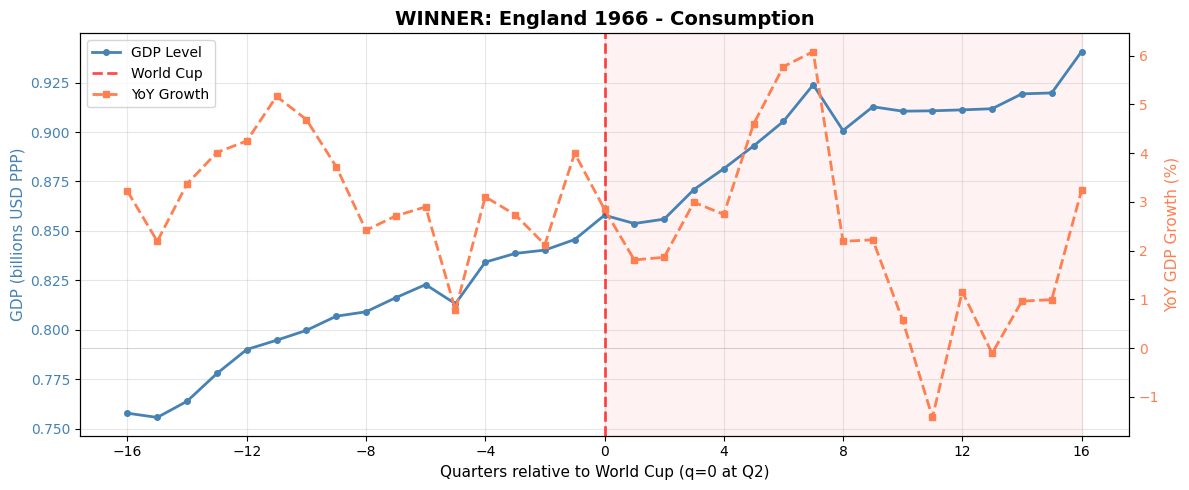

Saved: event descriptive plots\winner_consumption_DEU_1974.png


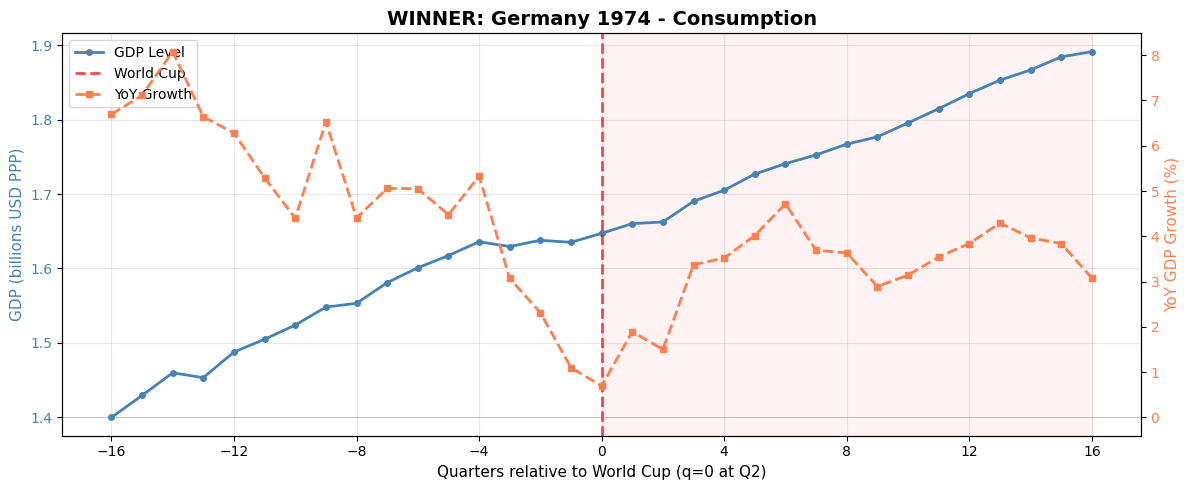

Insufficient data for WINNER: Argentina 1978 - Consumption
Saved: event descriptive plots\winner_consumption_ITA_1982.png


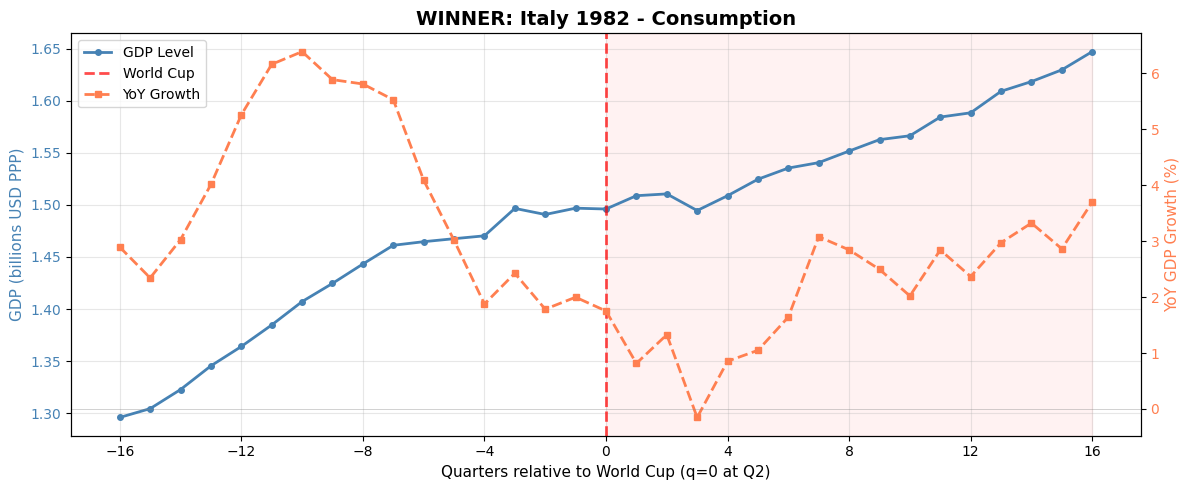

Insufficient data for WINNER: Argentina 1986 - Consumption
Saved: event descriptive plots\winner_consumption_DEU_1990.png


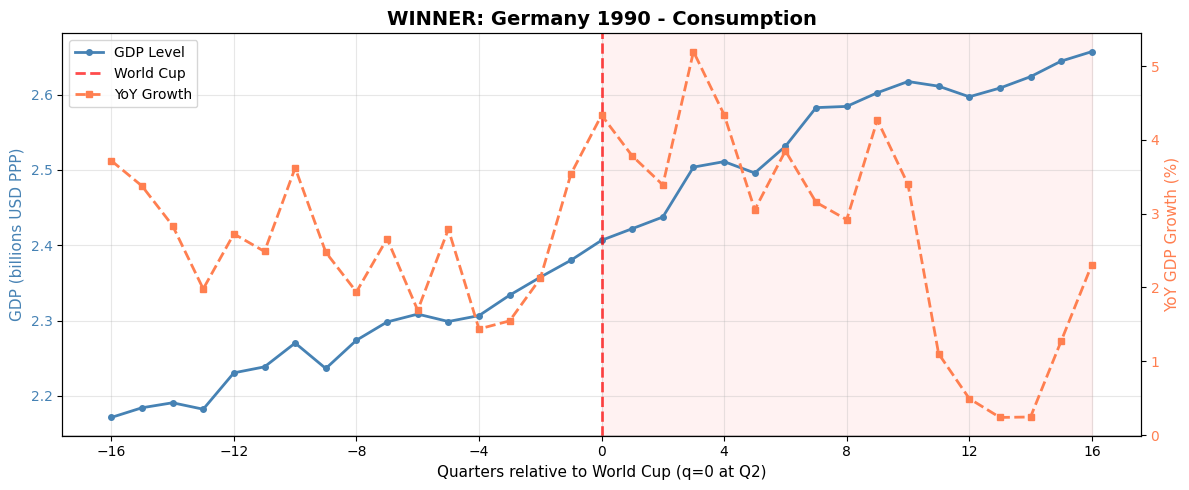

Insufficient data for WINNER: Brazil 1994 - Consumption
Saved: event descriptive plots\winner_consumption_FRA_1998.png


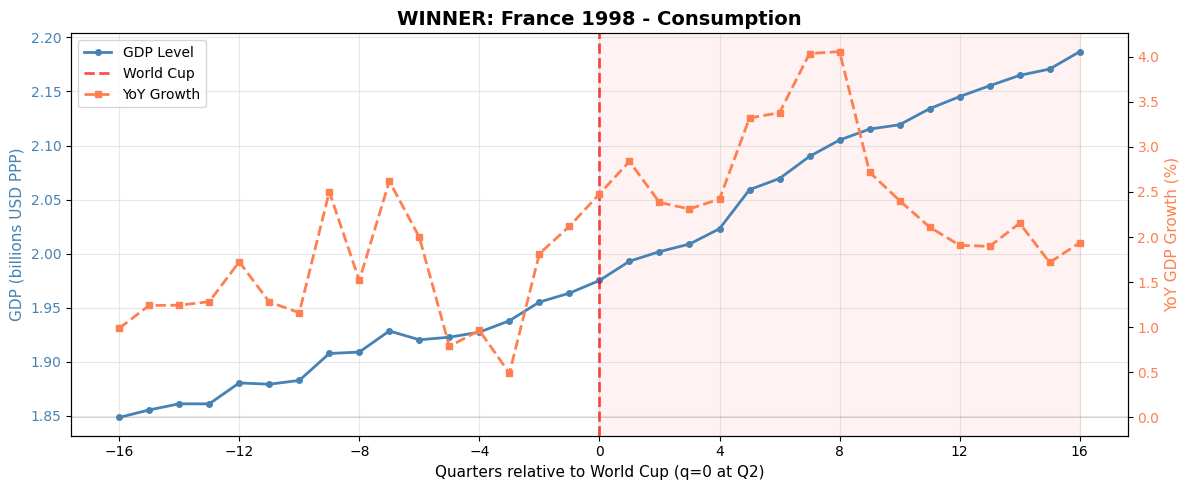

Saved: event descriptive plots\winner_consumption_BRA_2002.png


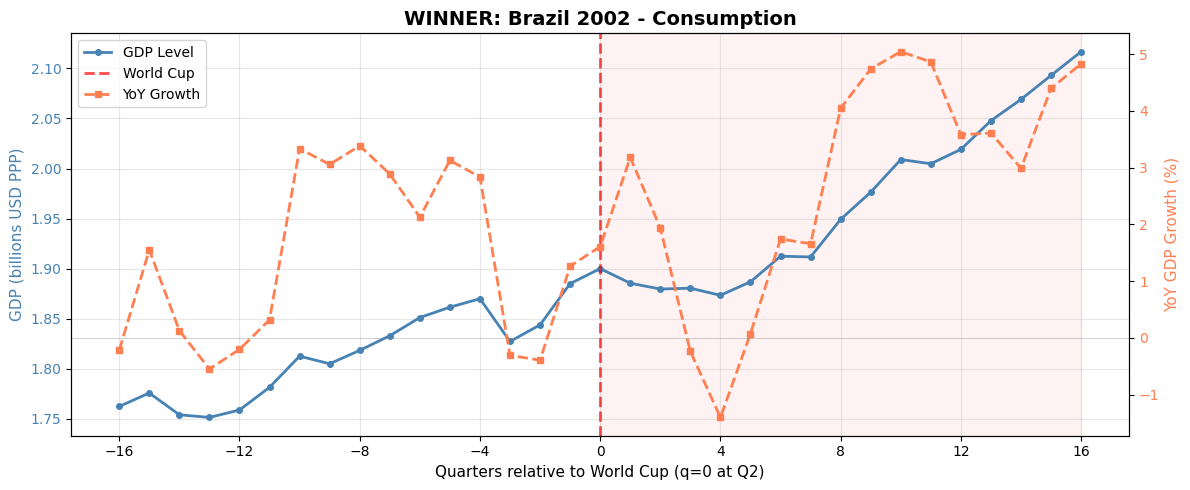

Saved: event descriptive plots\winner_consumption_ITA_2006.png


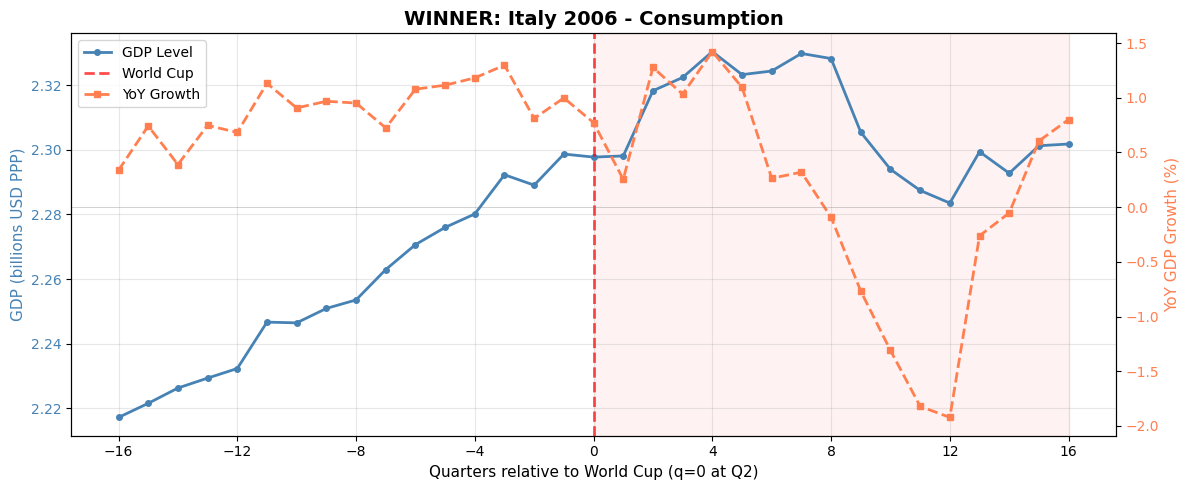

Saved: event descriptive plots\winner_consumption_ESP_2010.png


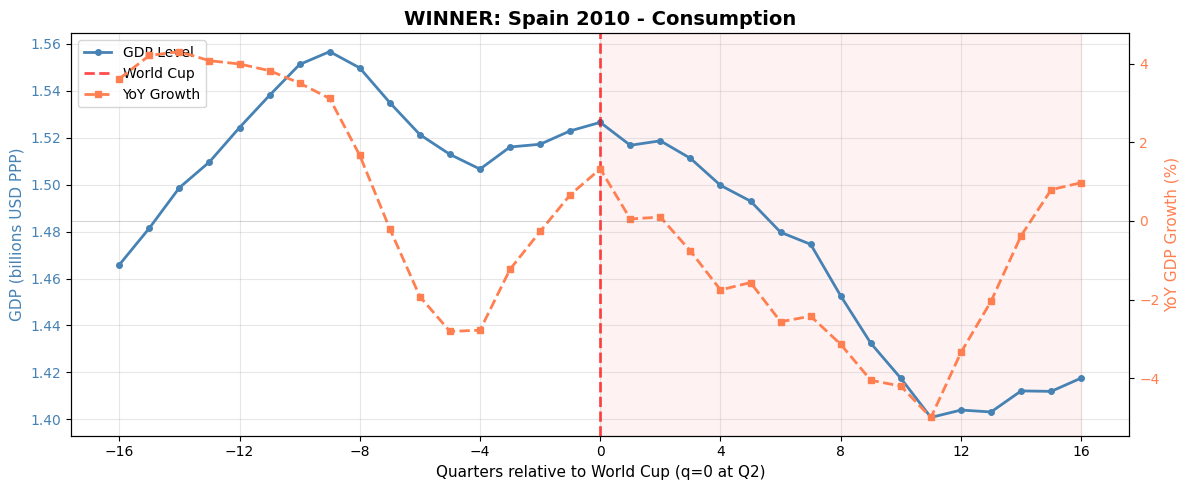

Saved: event descriptive plots\winner_consumption_DEU_2014.png


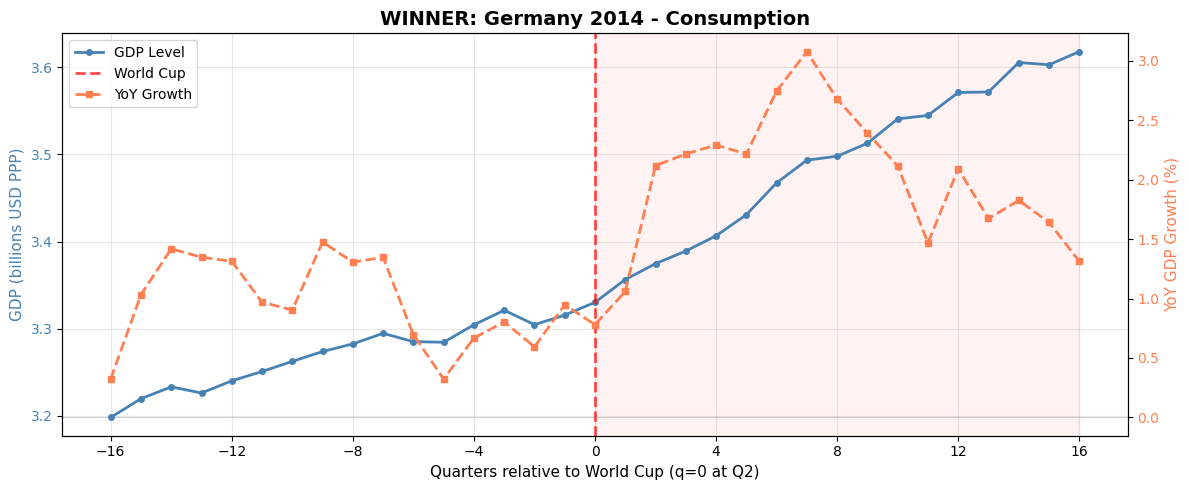

Saved: event descriptive plots\winner_consumption_FRA_2018.png


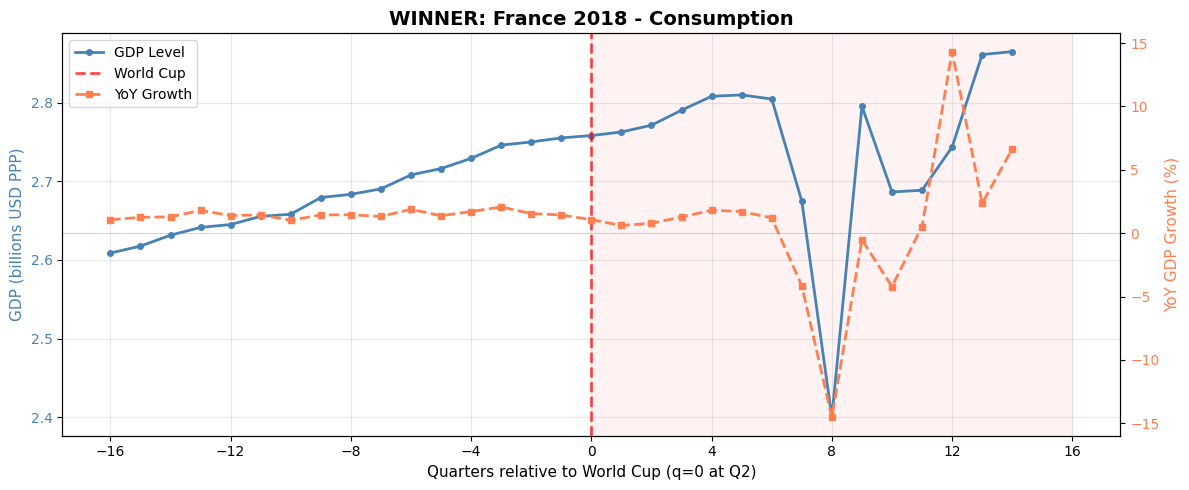



WORLD CUP WINNERS: INVESTMENT (±16 quarters)
Saved: event descriptive plots\winner_investment_GBR_1966.png


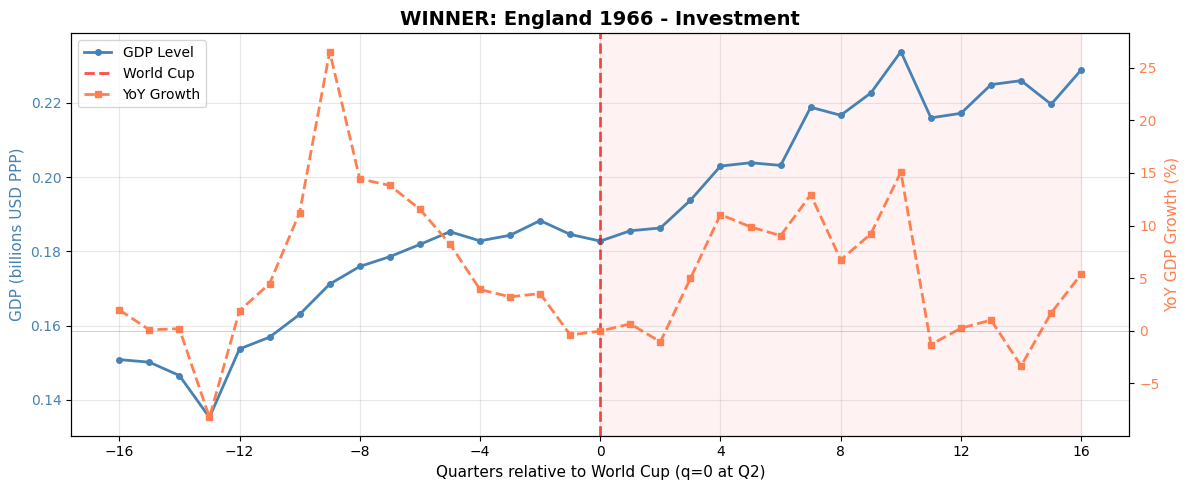

Saved: event descriptive plots\winner_investment_DEU_1974.png


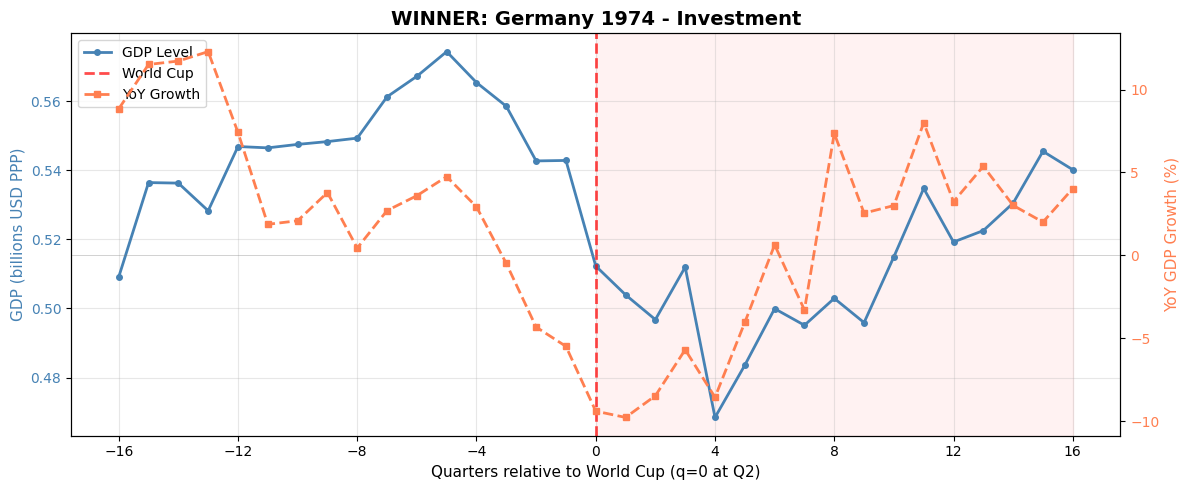

Insufficient data for WINNER: Argentina 1978 - Investment
Saved: event descriptive plots\winner_investment_ITA_1982.png


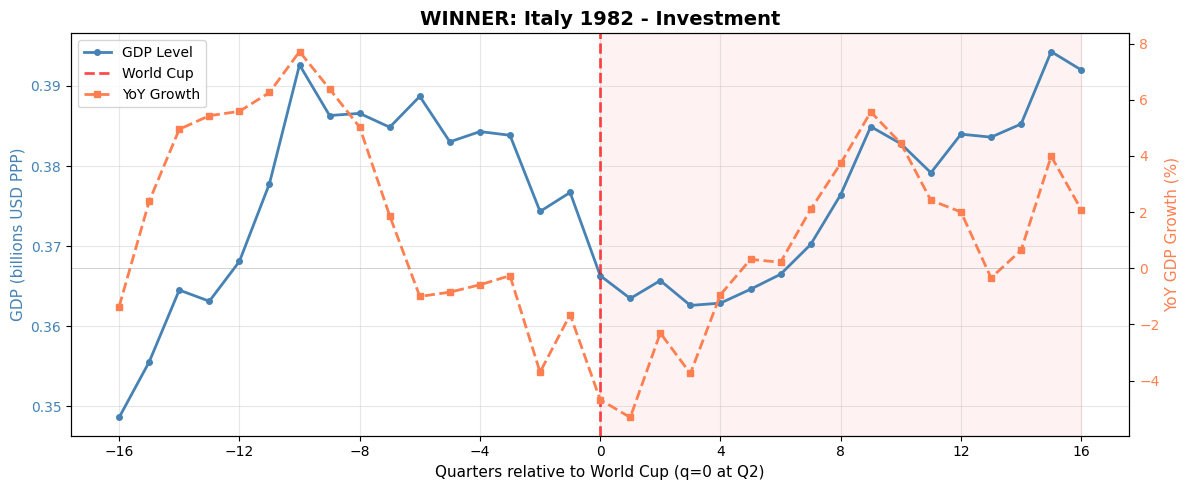

Insufficient data for WINNER: Argentina 1986 - Investment
Saved: event descriptive plots\winner_investment_DEU_1990.png


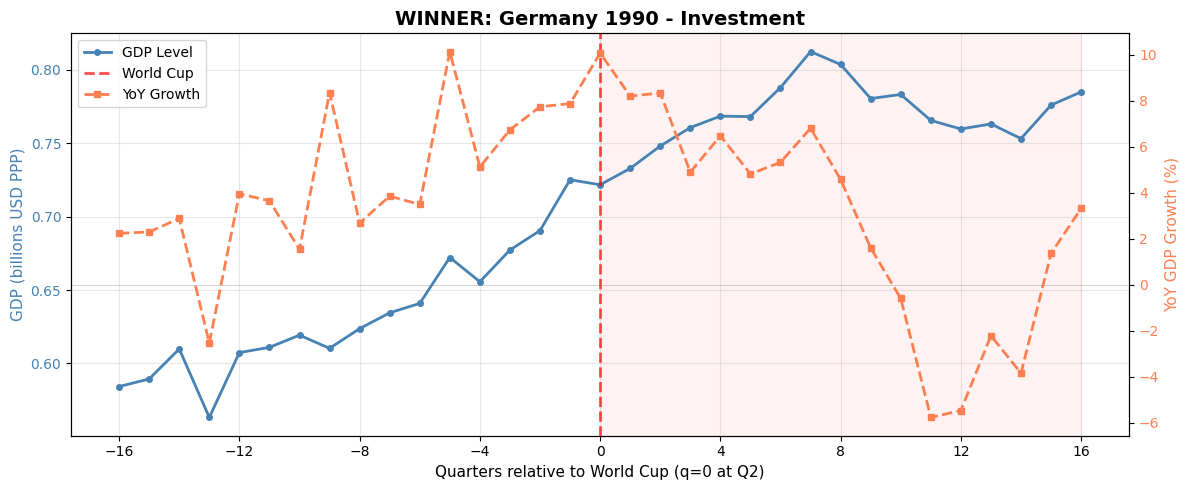

Insufficient data for WINNER: Brazil 1994 - Investment
Saved: event descriptive plots\winner_investment_FRA_1998.png


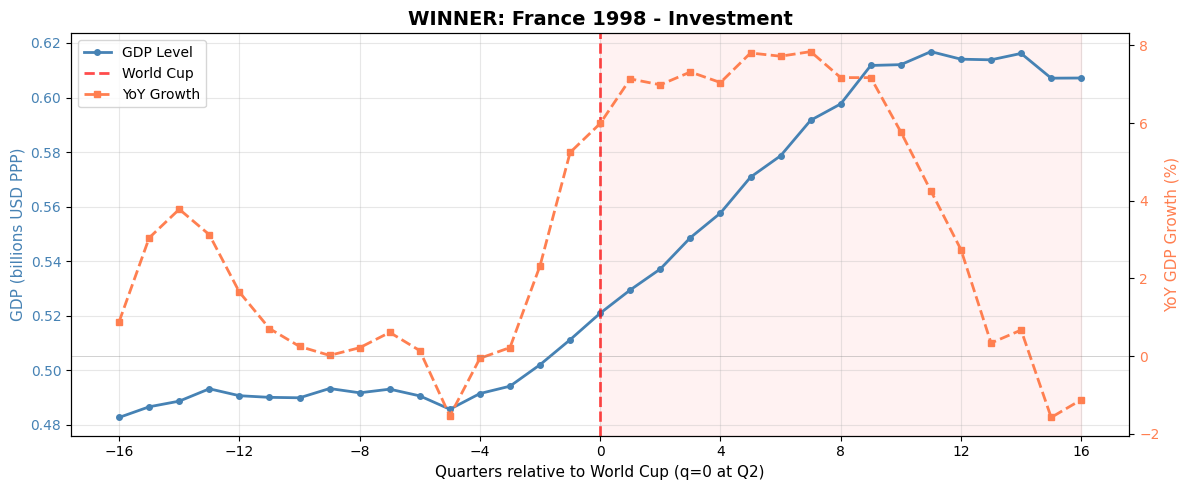

Saved: event descriptive plots\winner_investment_BRA_2002.png


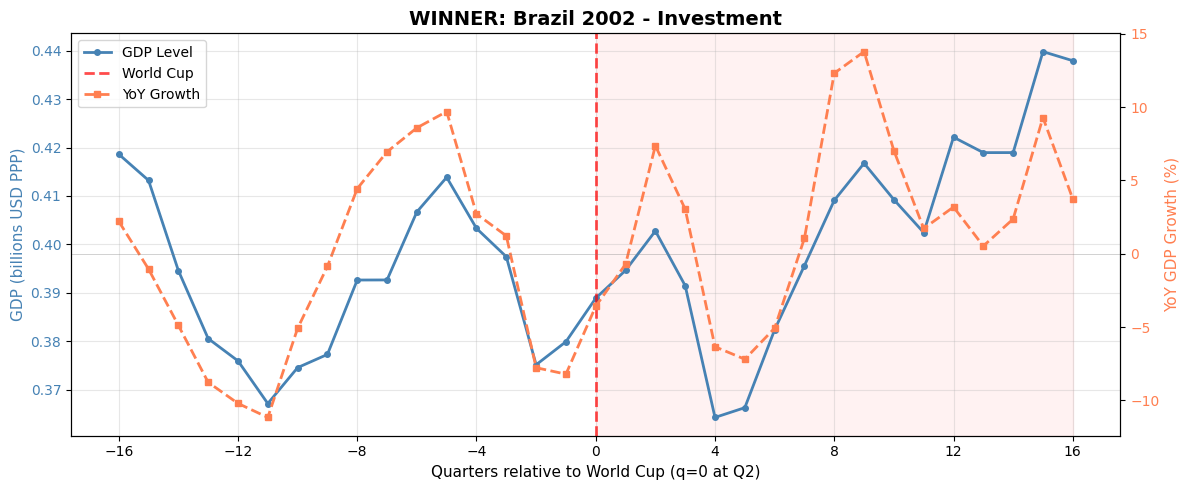

Saved: event descriptive plots\winner_investment_ITA_2006.png


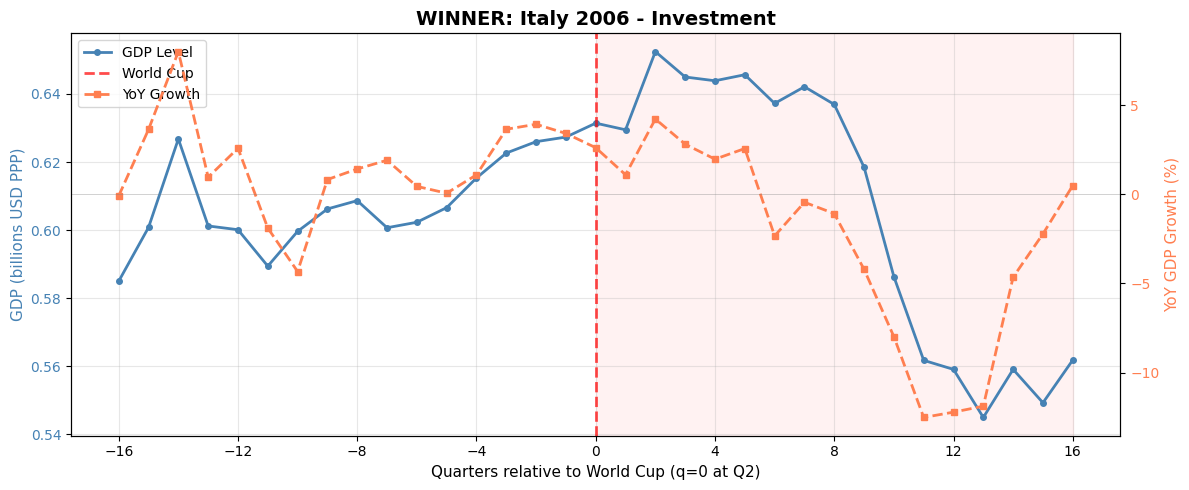

Saved: event descriptive plots\winner_investment_ESP_2010.png


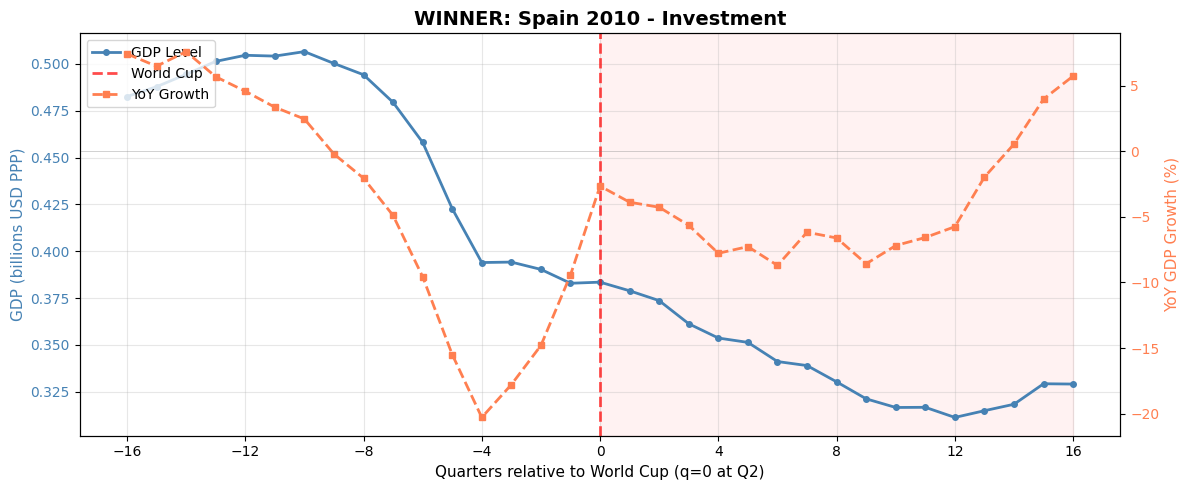

Saved: event descriptive plots\winner_investment_DEU_2014.png


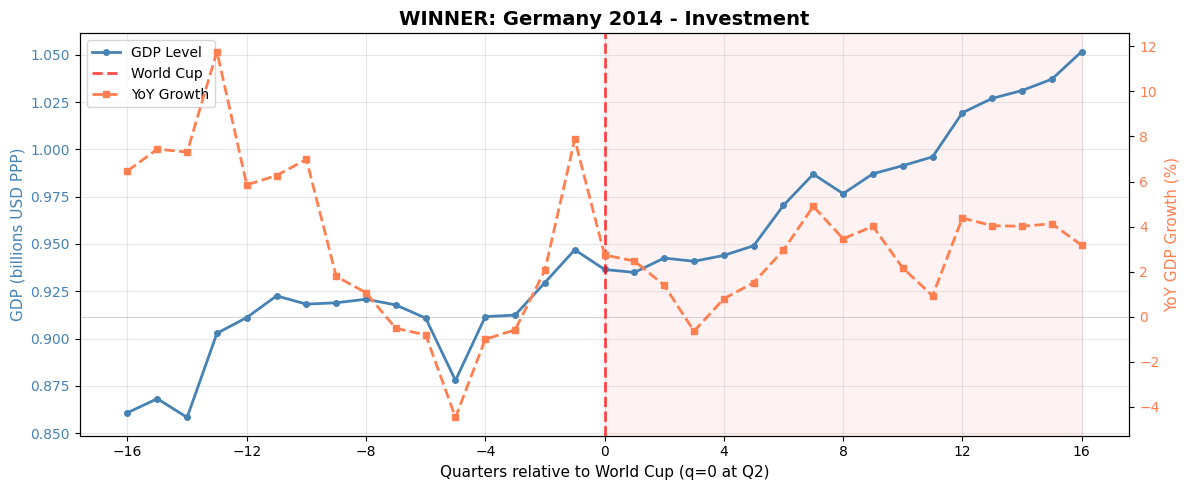

Saved: event descriptive plots\winner_investment_FRA_2018.png


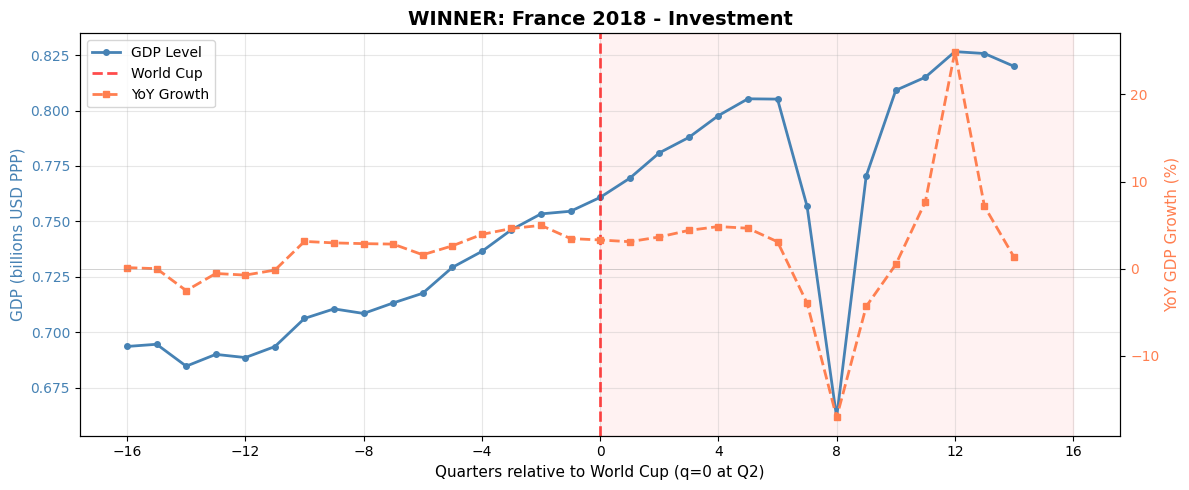



WORLD CUP WINNERS: EXPORTS (±16 quarters)
Saved: event descriptive plots\winner_exports_GBR_1966.png


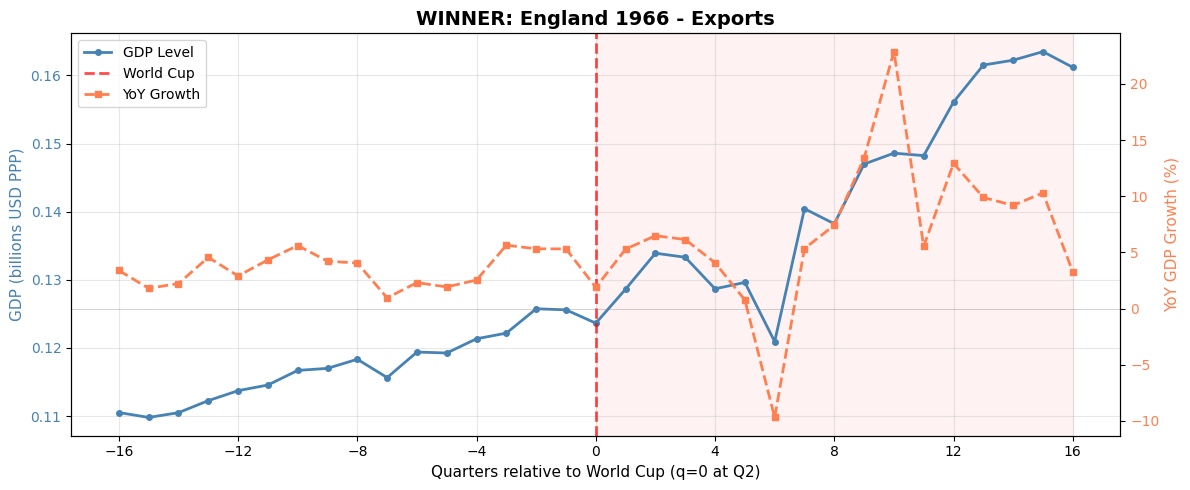

Saved: event descriptive plots\winner_exports_DEU_1974.png


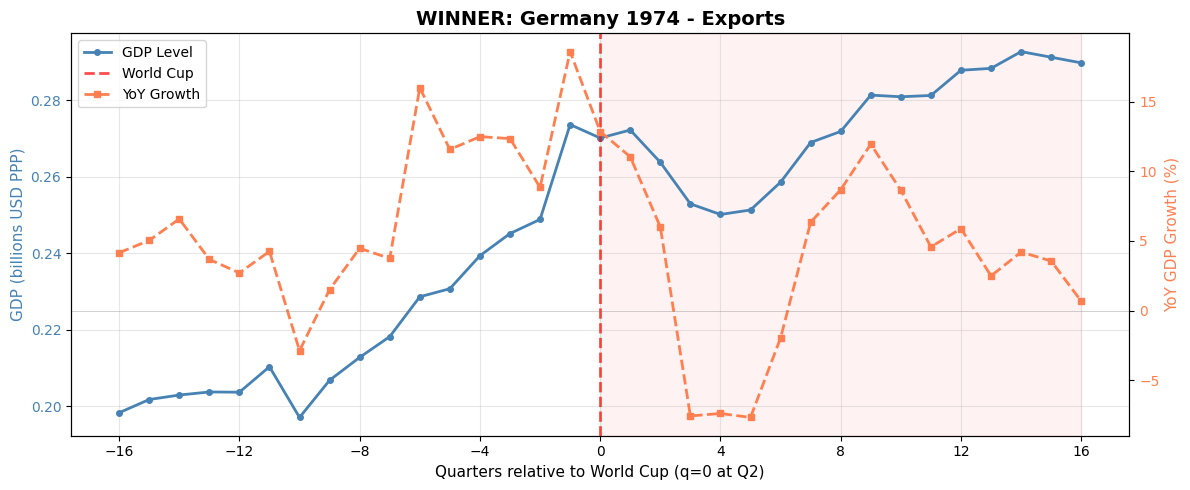

Insufficient data for WINNER: Argentina 1978 - Exports
Saved: event descriptive plots\winner_exports_ITA_1982.png


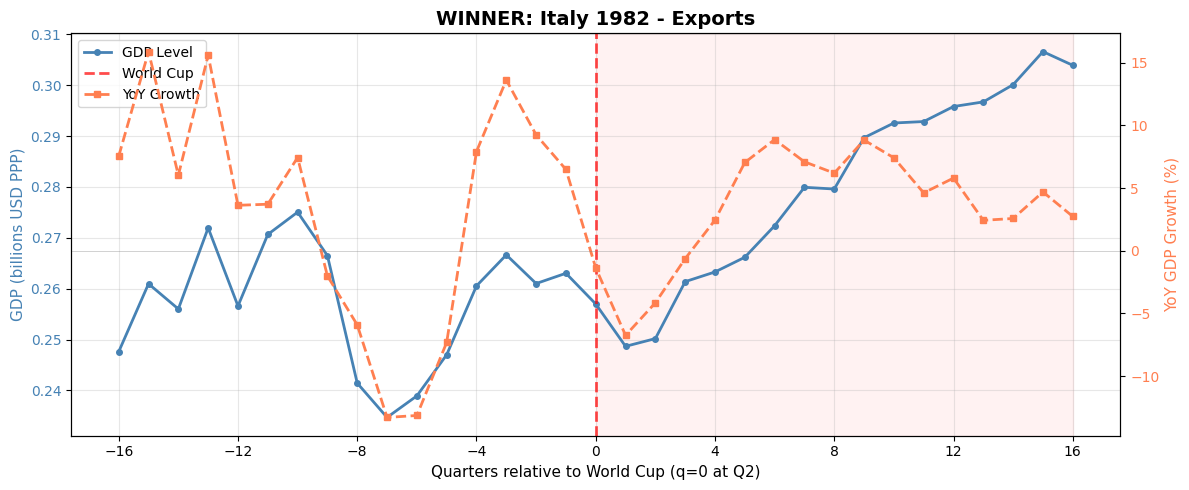

Insufficient data for WINNER: Argentina 1986 - Exports
Saved: event descriptive plots\winner_exports_DEU_1990.png


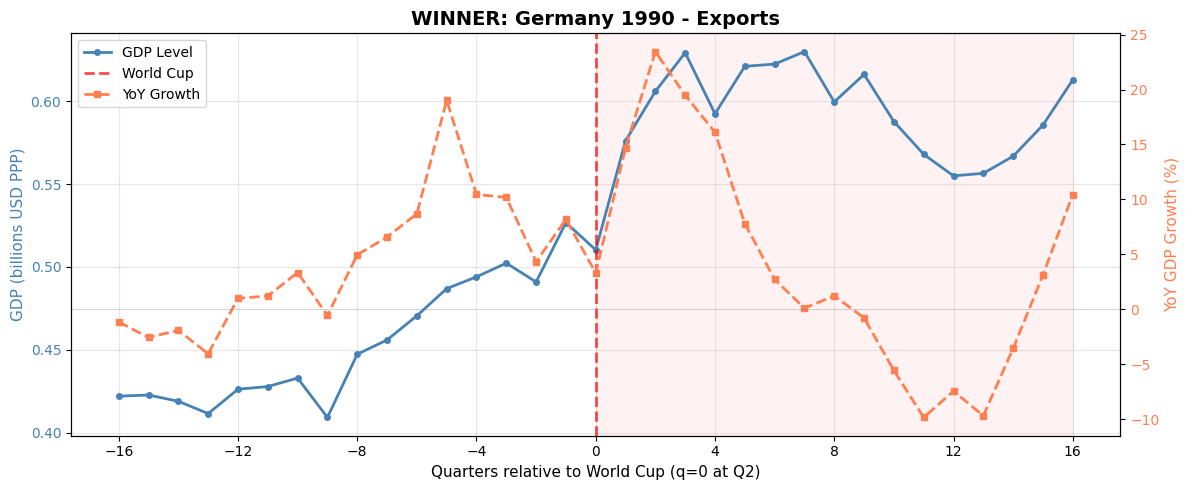

Insufficient data for WINNER: Brazil 1994 - Exports
Saved: event descriptive plots\winner_exports_FRA_1998.png


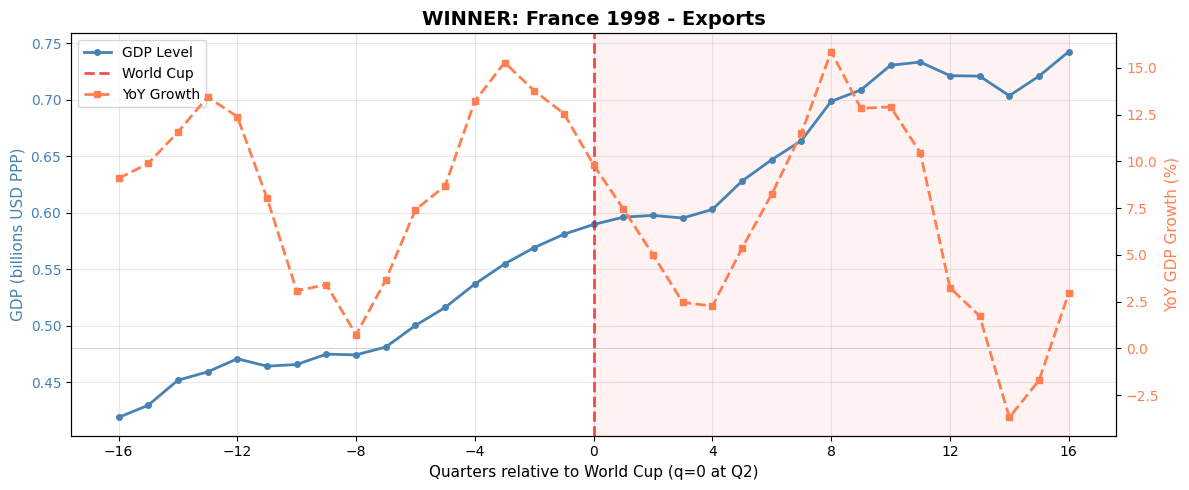

Saved: event descriptive plots\winner_exports_BRA_2002.png


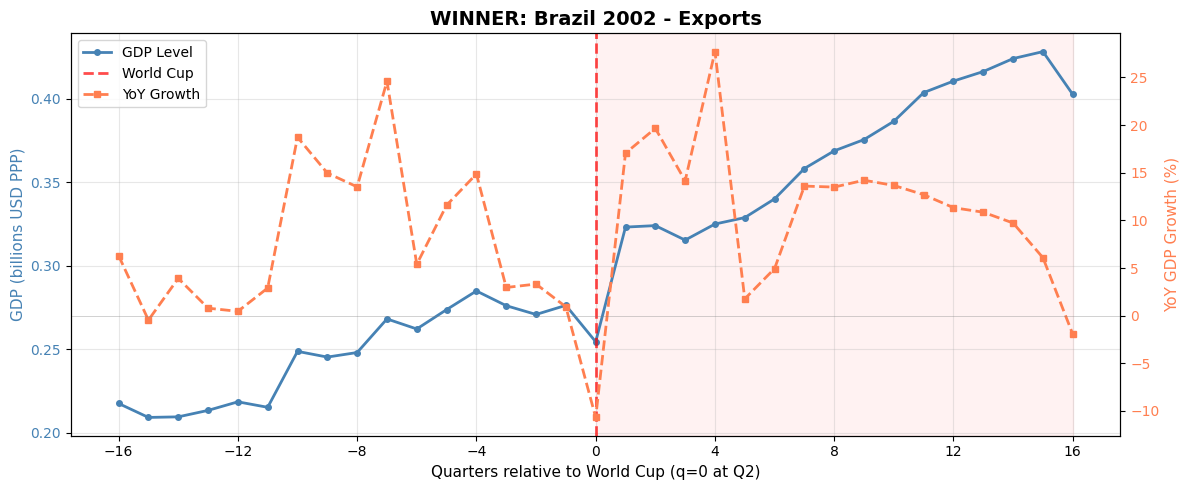

Saved: event descriptive plots\winner_exports_ITA_2006.png


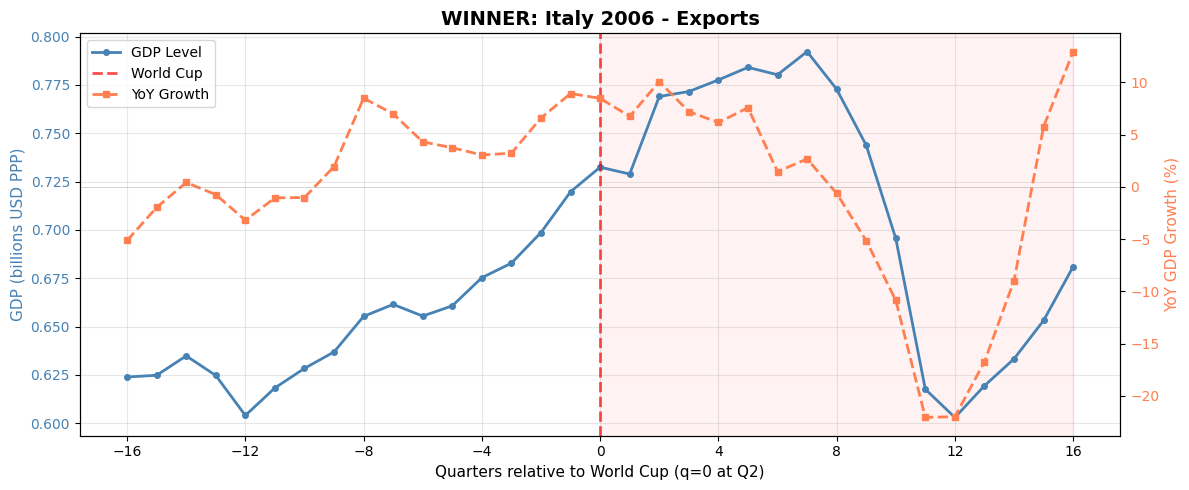

Saved: event descriptive plots\winner_exports_ESP_2010.png


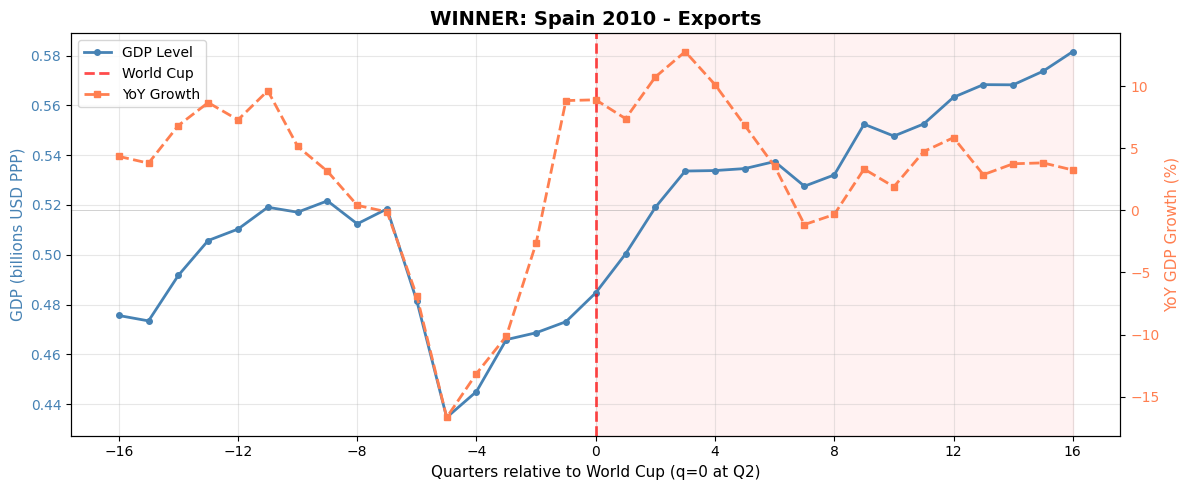

Saved: event descriptive plots\winner_exports_DEU_2014.png


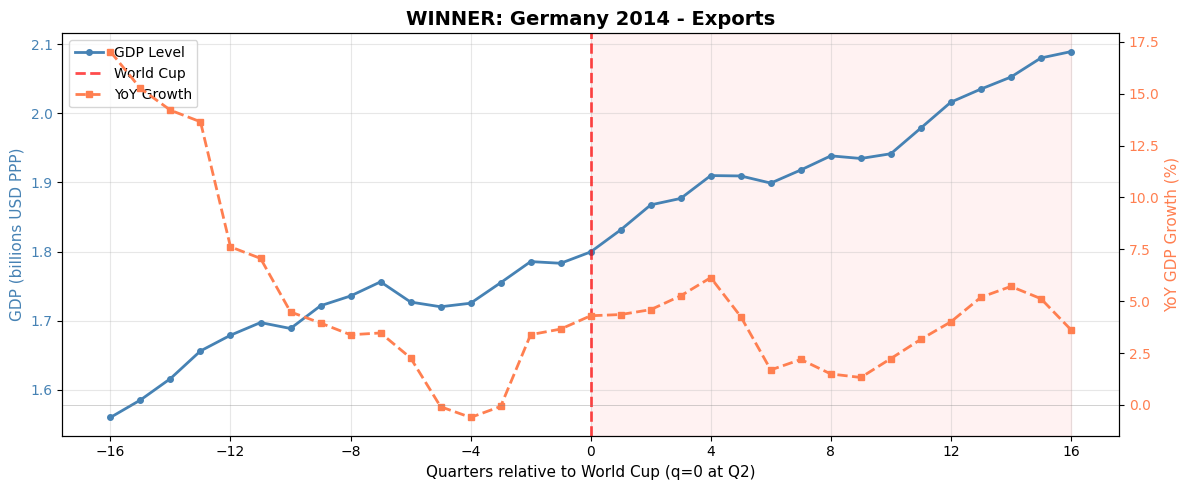

Saved: event descriptive plots\winner_exports_FRA_2018.png


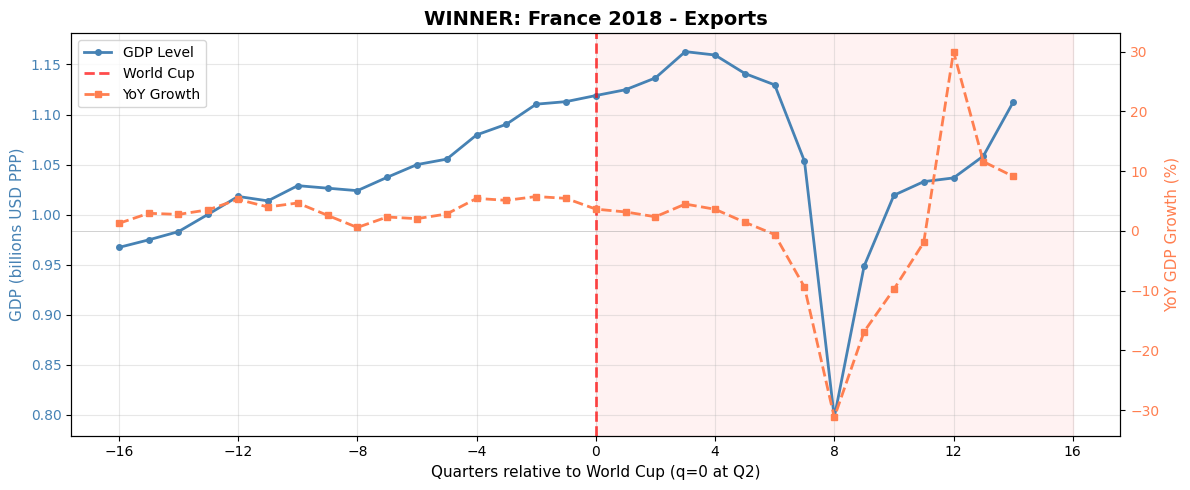



WORLD CUP WINNERS: IMPORTS (±16 quarters)
Saved: event descriptive plots\winner_imports_GBR_1966.png


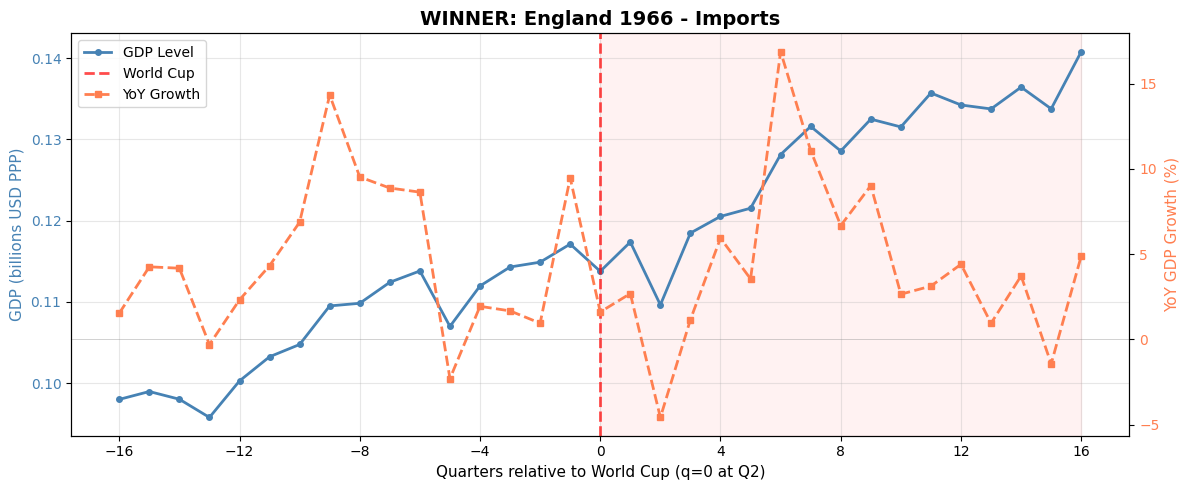

Saved: event descriptive plots\winner_imports_DEU_1974.png


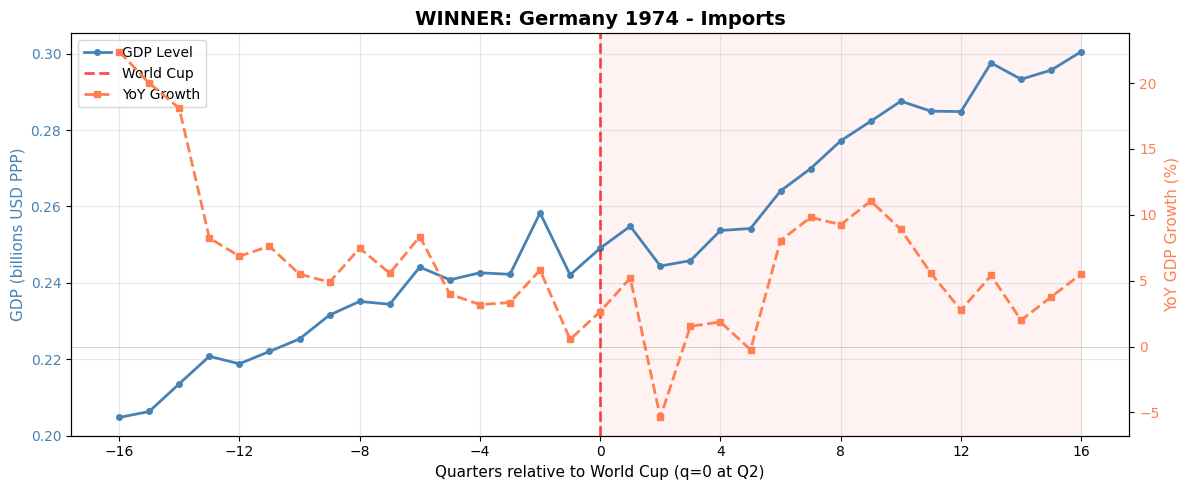

Insufficient data for WINNER: Argentina 1978 - Imports
Saved: event descriptive plots\winner_imports_ITA_1982.png


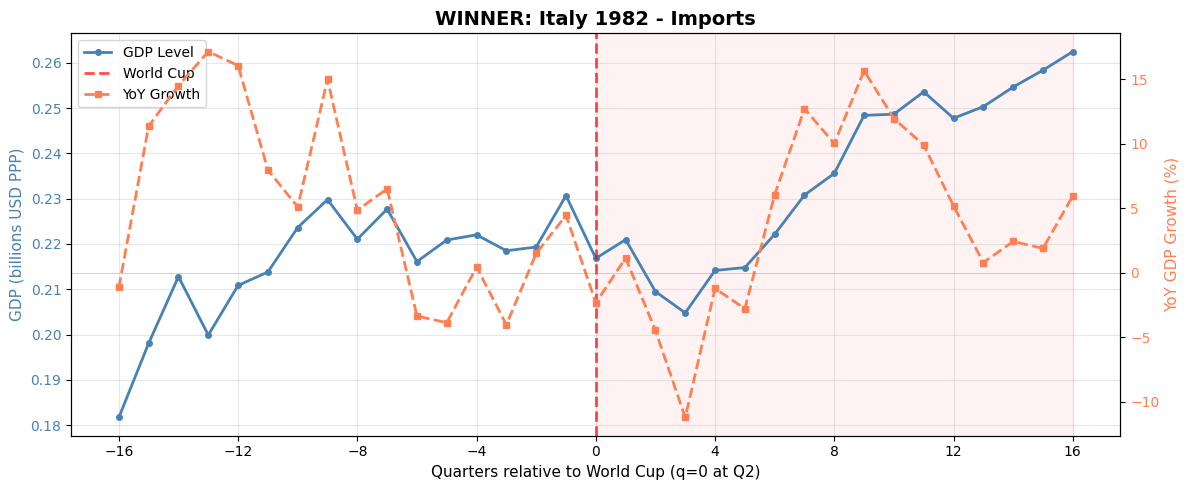

Insufficient data for WINNER: Argentina 1986 - Imports
Saved: event descriptive plots\winner_imports_DEU_1990.png


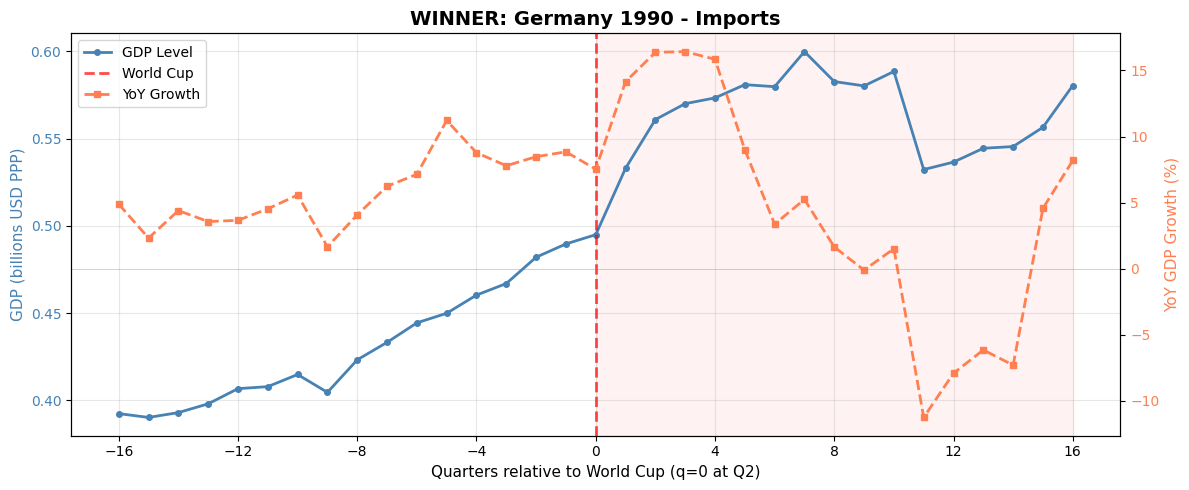

Insufficient data for WINNER: Brazil 1994 - Imports
Saved: event descriptive plots\winner_imports_FRA_1998.png


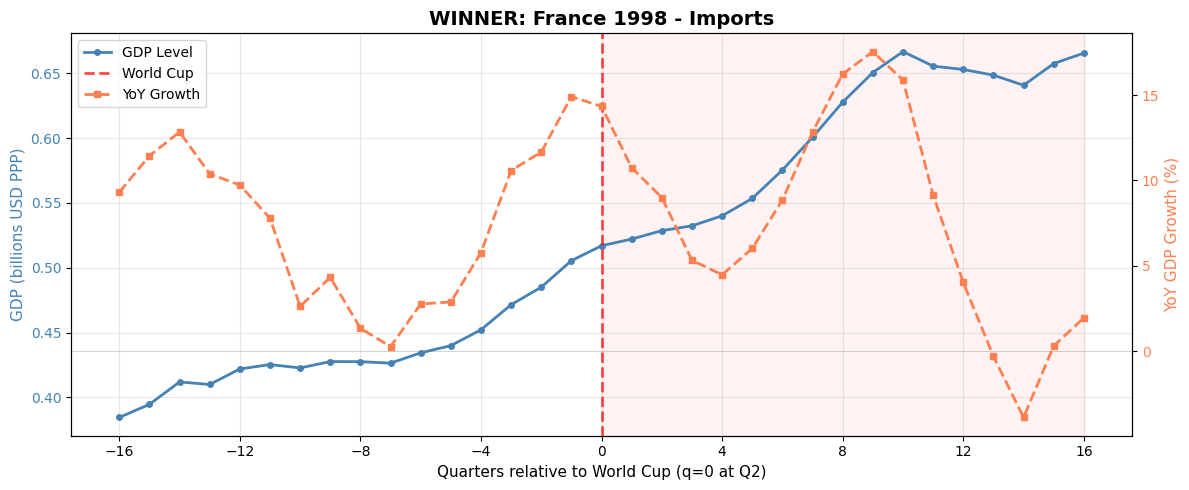

Saved: event descriptive plots\winner_imports_BRA_2002.png


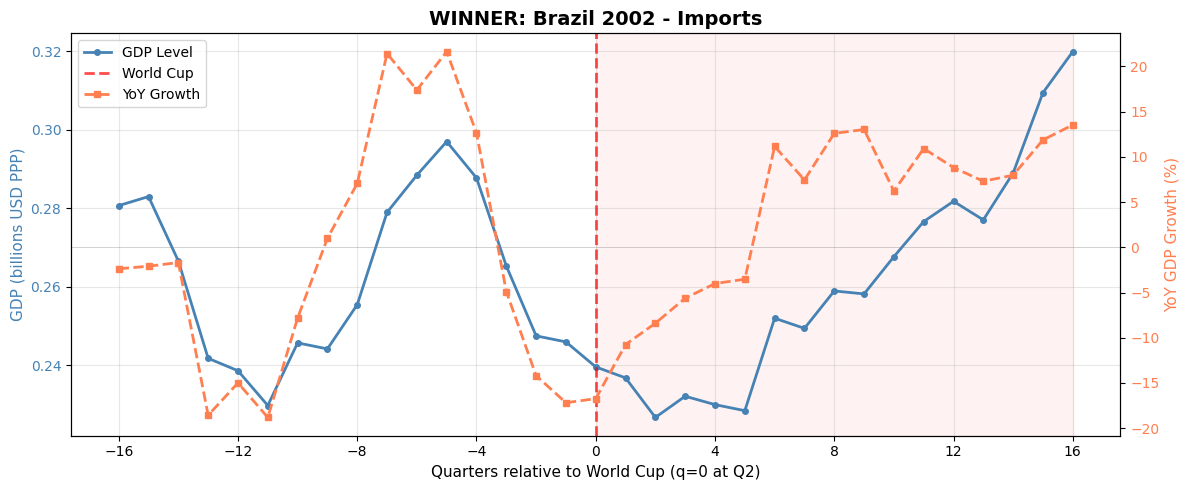

Saved: event descriptive plots\winner_imports_ITA_2006.png


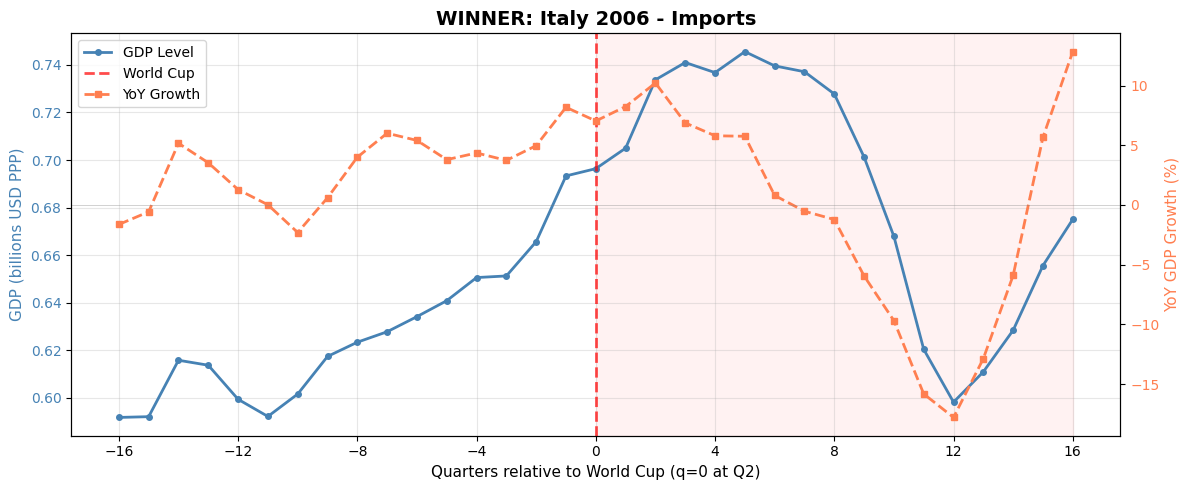

Saved: event descriptive plots\winner_imports_ESP_2010.png


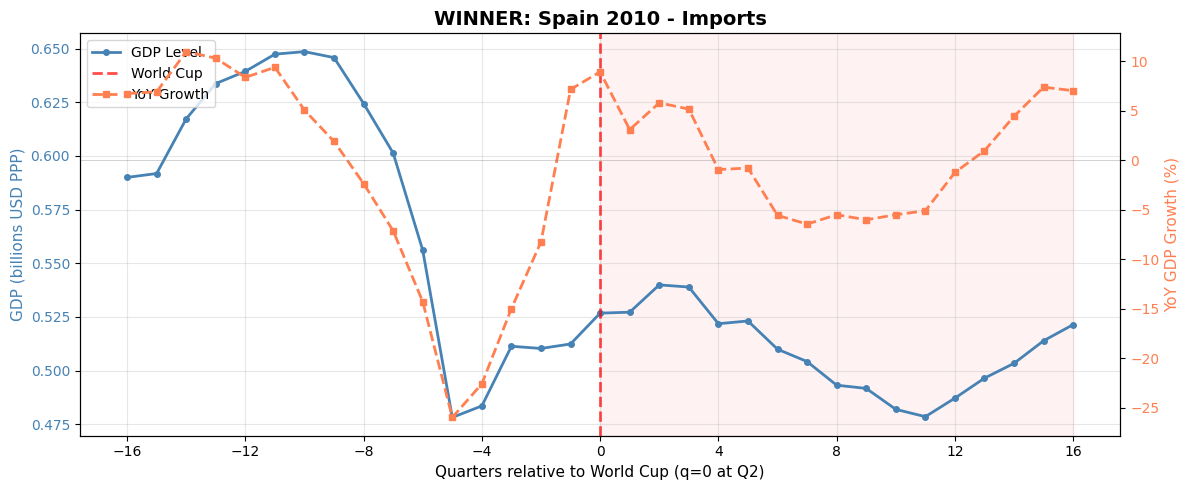

Saved: event descriptive plots\winner_imports_DEU_2014.png


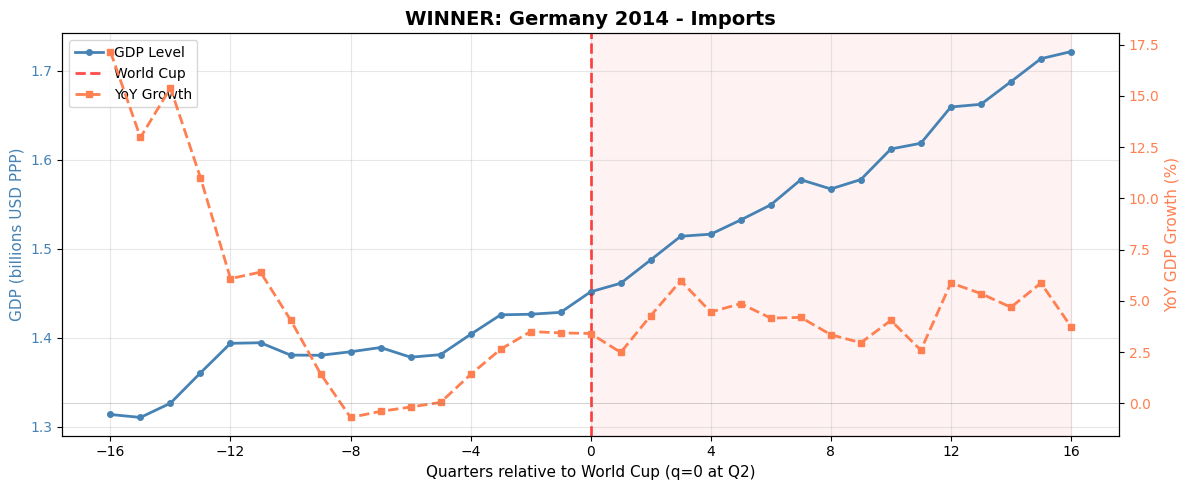

Saved: event descriptive plots\winner_imports_FRA_2018.png


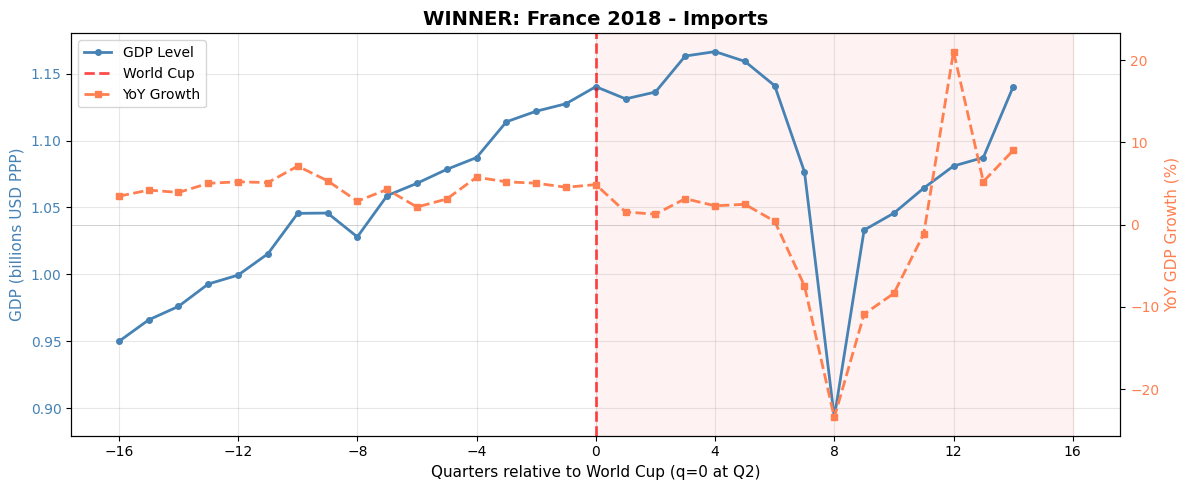

In [21]:
# Plot all features for each World Cup winner (excluding GDP which is already plotted)

for level_col, feature_name in FEATURES[1:]:  # Skip GDP (index 0)
    yoy_col_feat = f'{level_col}_yoy_pct'
    
    print("=" * 70)
    print(f"WORLD CUP WINNERS: {feature_name.upper()} (±16 quarters)")
    print("=" * 70)
    
    for country, year, title in winners:
        filename = f"winner_{feature_name.lower()}_{country}_{year}.png"
        save_path = os.path.join(OUTPUT_DIR, filename)
        fig = plot_event(df, country, year, f"WINNER: {title} - {feature_name}", 
                        level_col, yoy_col_feat, save_path=save_path)
        if fig:
            plt.show()
            plt.close(fig)
    print("\n")

## Summary: All Features Overlay for Winners

Saved: event descriptive plots\summary_winners_gdp_overlay.png


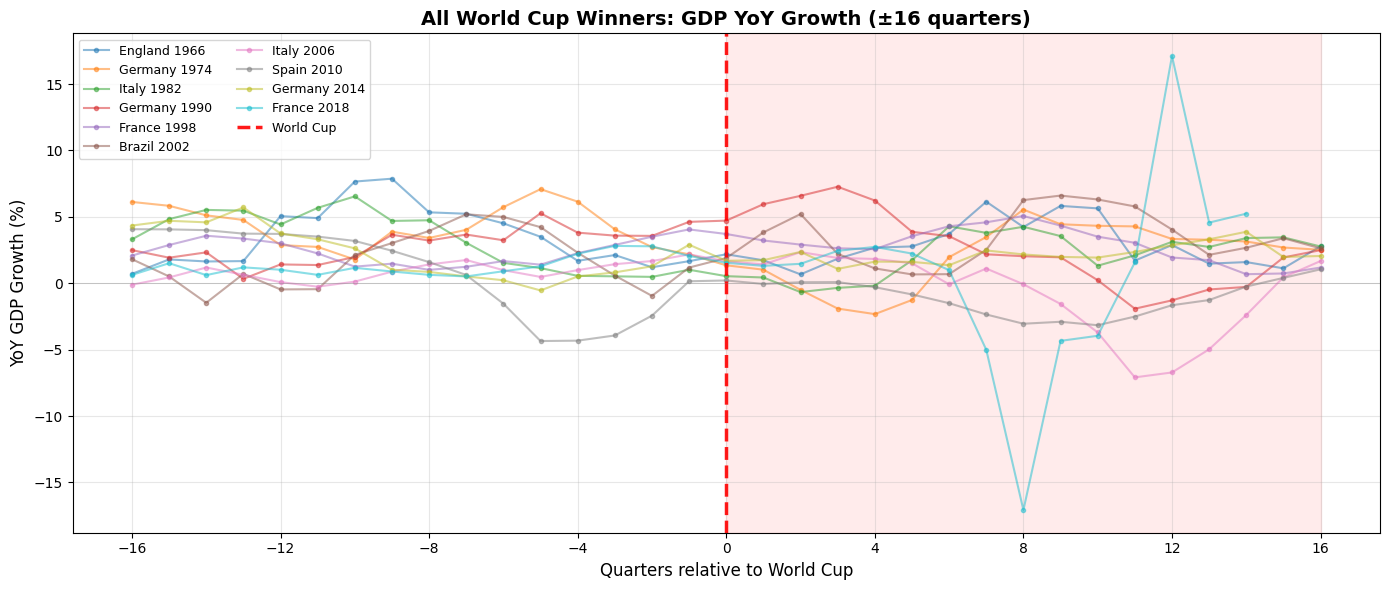

Saved: event descriptive plots\summary_winners_consumption_overlay.png


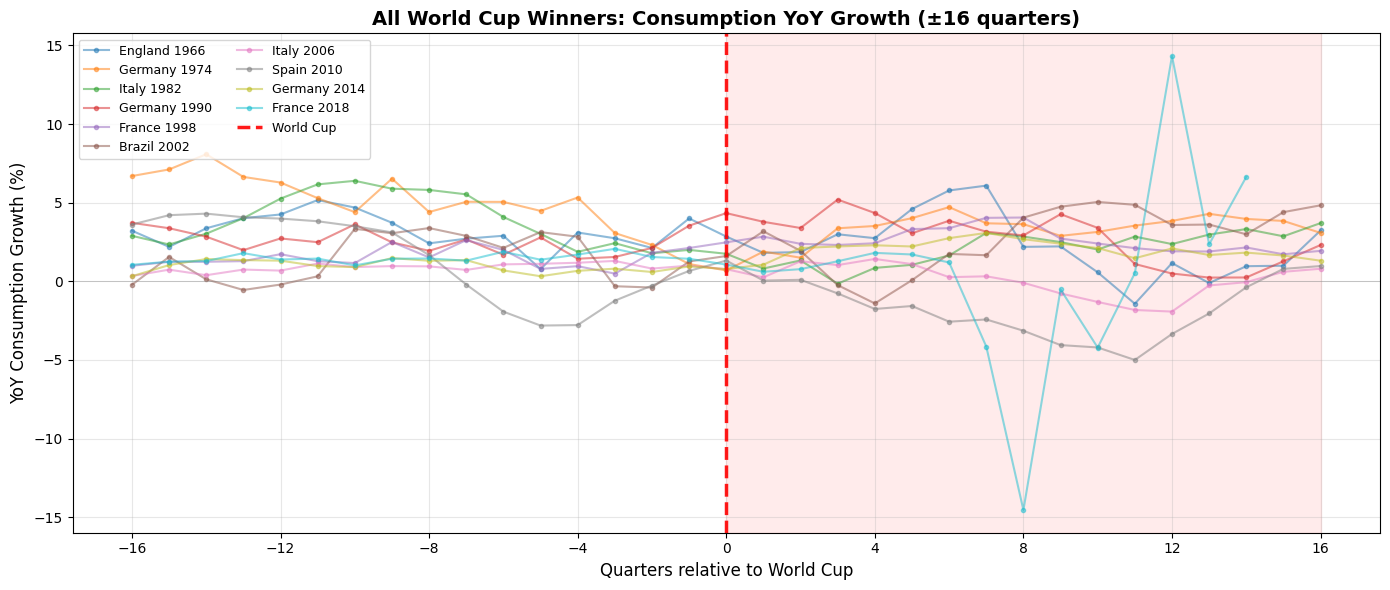

Saved: event descriptive plots\summary_winners_investment_overlay.png


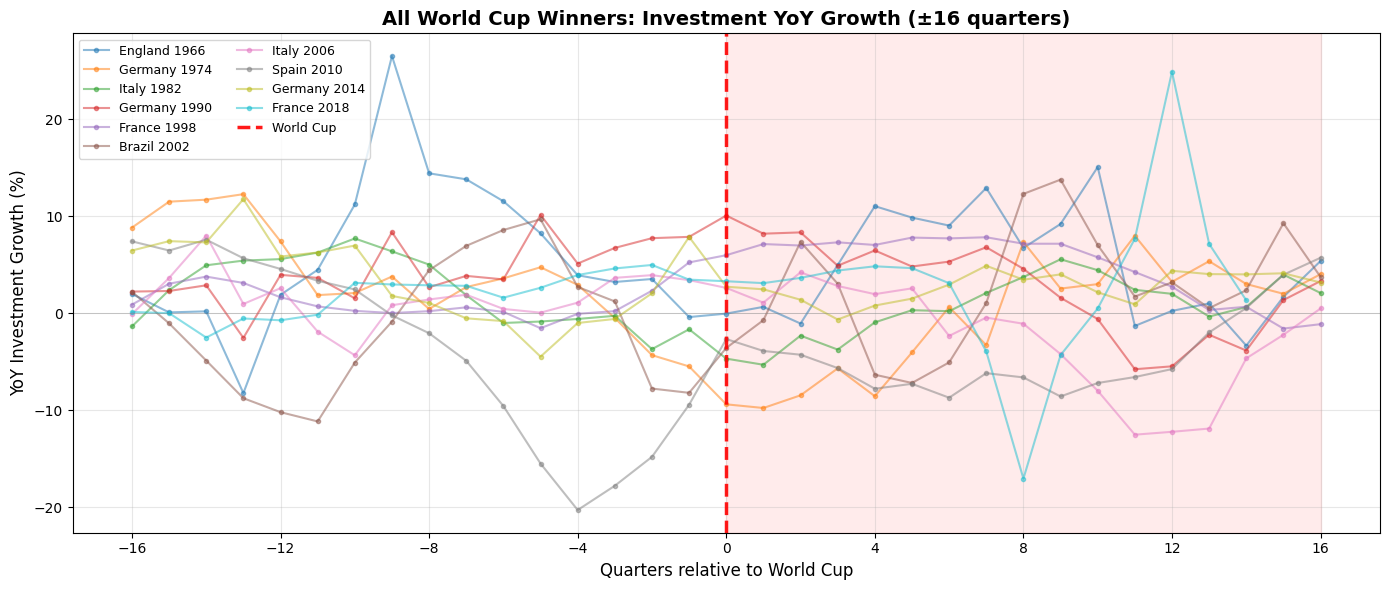

Saved: event descriptive plots\summary_winners_exports_overlay.png


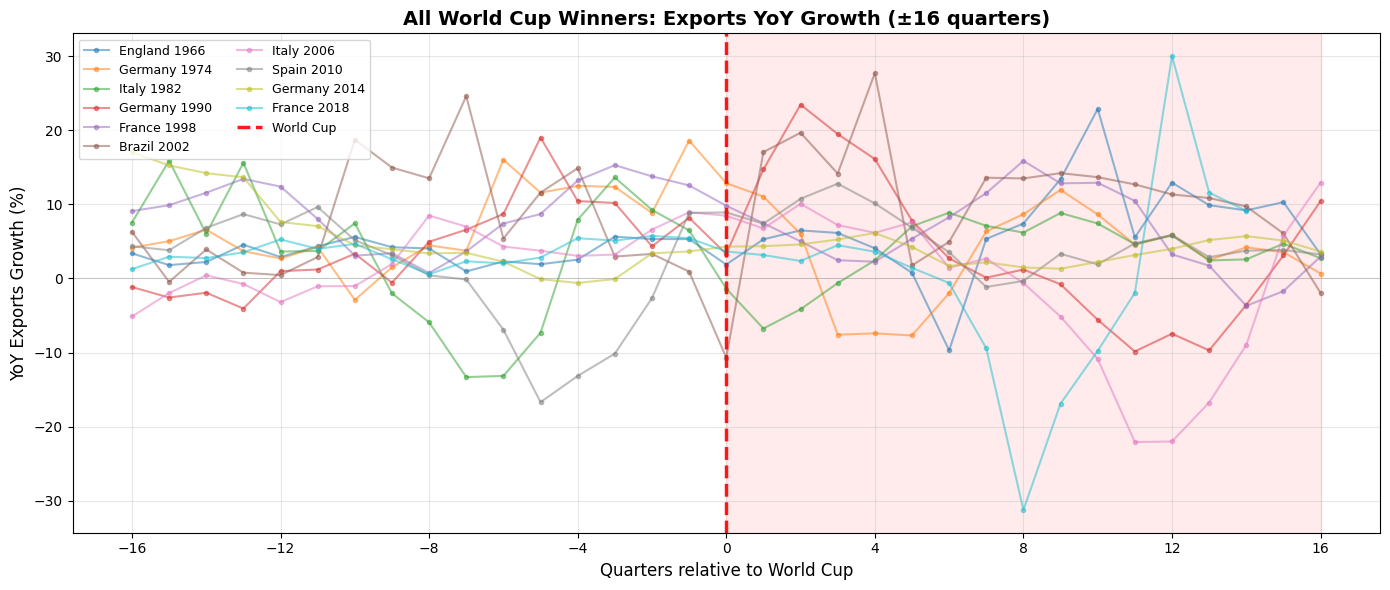

Saved: event descriptive plots\summary_winners_imports_overlay.png


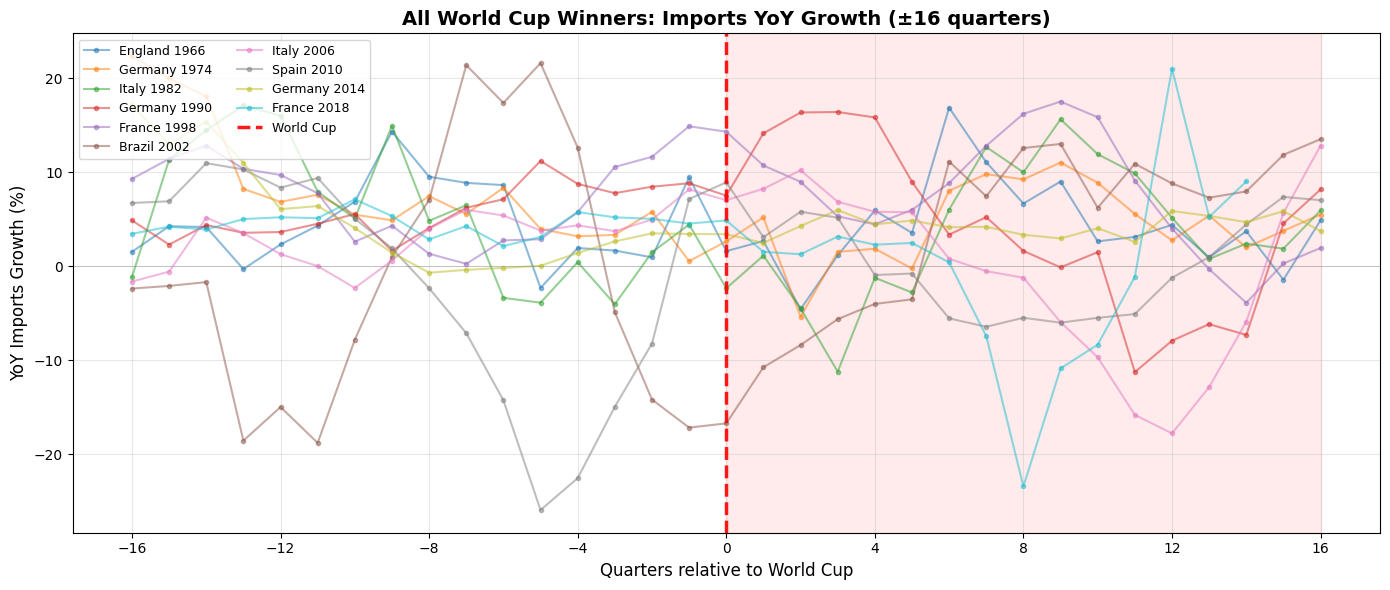

In [22]:
# Overlay plots: All winners for each feature

for level_col, feature_name in FEATURES:
    yoy_col_feat = f'{level_col}_yoy_pct'
    
    # Extract series for this feature
    feat_df = extract_event_series(df, winners, level_col, yoy_col_feat)
    
    if len(feat_df) == 0:
        print(f"No data for {feature_name}")
        continue
    
    # Create overlay plot
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Plot each winner event
    for event_label in feat_df['event_label'].unique():
        event_data = feat_df[feat_df['event_label'] == event_label]
        ax.plot(event_data['rel_time'], event_data[yoy_col_feat], 'o-', alpha=0.5, 
                linewidth=1.5, markersize=3, label=event_label)
    
    # World Cup marker
    ax.axvline(0, color='red', linestyle='--', linewidth=2.5, alpha=0.9, label='World Cup')
    ax.axhline(0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
    ax.axvspan(0, 16, alpha=0.08, color='red')
    
    ax.set_xlabel('Quarters relative to World Cup', fontsize=12)
    ax.set_ylabel(f'YoY {feature_name} Growth (%)', fontsize=12)
    ax.set_title(f'All World Cup Winners: {feature_name} YoY Growth (±16 quarters)', 
                fontsize=14, fontweight='bold')
    ax.set_xticks(range(-16, 17, 4))
    ax.legend(loc='upper left', fontsize=9, ncol=2)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    save_path = os.path.join(OUTPUT_DIR, f'summary_winners_{feature_name.lower()}_overlay.png')
    fig.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"Saved: {save_path}")
    plt.show()
    plt.close(fig)

## Summary: Average YoY Growth by Feature (Winners)

Saved: event descriptive plots\summary_winners_all_features_avg.png


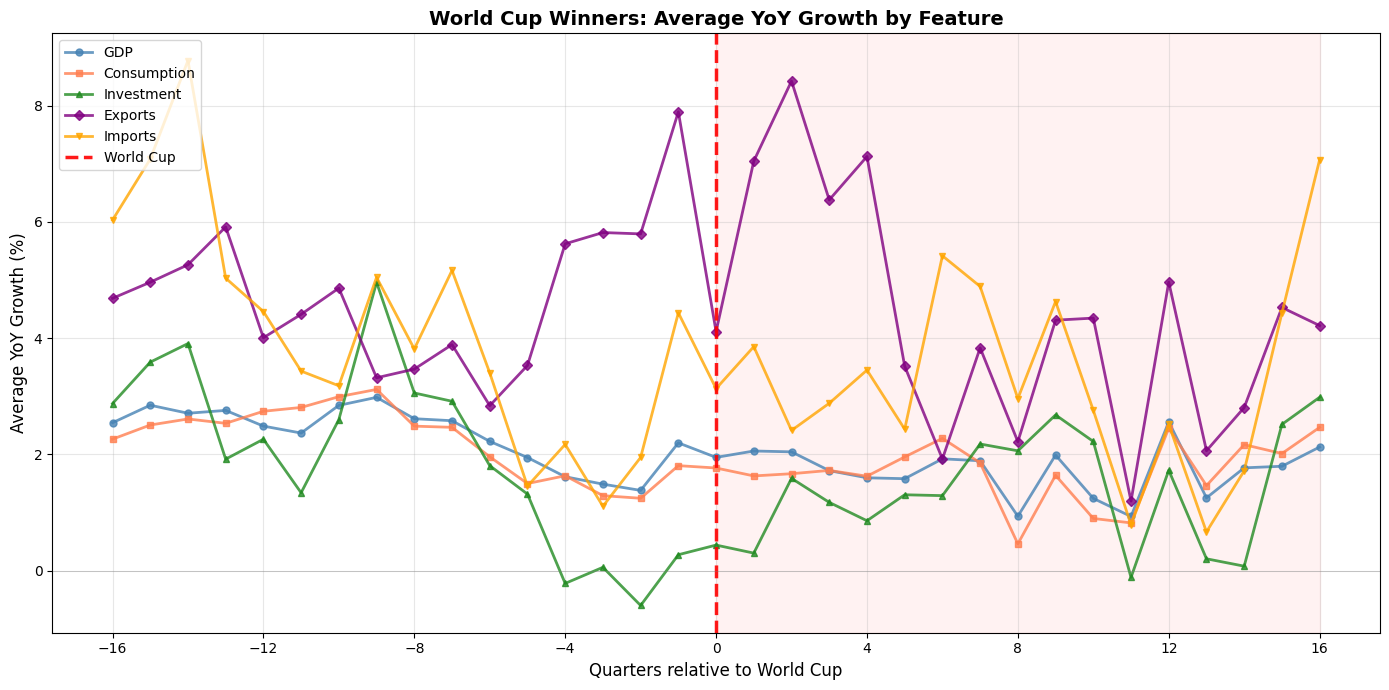

In [23]:
# Combined plot: Average YoY growth for all features (Winners)

fig, ax = plt.subplots(figsize=(14, 7))

colors = ['steelblue', 'coral', 'forestgreen', 'purple', 'orange']
markers = ['o', 's', '^', 'D', 'v']

for i, (level_col, feature_name) in enumerate(FEATURES):
    yoy_col_feat = f'{level_col}_yoy_pct'
    
    # Extract series
    feat_df = extract_event_series(df, winners, level_col, yoy_col_feat)
    
    if len(feat_df) == 0:
        continue
    
    # Calculate average
    avg_series = feat_df.groupby('rel_time')[yoy_col_feat].mean()
    
    ax.plot(avg_series.index, avg_series.values, f'{markers[i]}-', 
            color=colors[i], linewidth=2, markersize=5, 
            label=f'{feature_name}', alpha=0.8)

# World Cup marker
ax.axvline(0, color='red', linestyle='--', linewidth=2.5, alpha=0.9, label='World Cup')
ax.axhline(0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
ax.axvspan(0, 16, alpha=0.05, color='red')

ax.set_xlabel('Quarters relative to World Cup', fontsize=12)
ax.set_ylabel('Average YoY Growth (%)', fontsize=12)
ax.set_title('World Cup Winners: Average YoY Growth by Feature', fontsize=14, fontweight='bold')
ax.set_xticks(range(-16, 17, 4))
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
save_path = os.path.join(OUTPUT_DIR, 'summary_winners_all_features_avg.png')
fig.savefig(save_path, dpi=150, bbox_inches='tight')
print(f"Saved: {save_path}")
plt.show()
plt.close(fig)

In [24]:
# List all saved plots
print("=" * 60)
print("ALL SAVED PLOTS")
print("=" * 60)
saved_files = sorted([f for f in os.listdir(OUTPUT_DIR) if f.endswith('.png')])
print(f"Total: {len(saved_files)} plots saved to '{OUTPUT_DIR}/'")
print()
for f in saved_files:
    print(f"  {f}")

ALL SAVED PLOTS
Total: 73 plots saved to 'event descriptive plots/'

  host_BRA_2014.png
  host_DEU_1974.png
  host_DEU_2006.png
  host_ESP_1982.png
  host_FRA_1998.png
  host_GBR_1966.png
  host_ITA_1990.png
  host_JPN_2002.png
  host_KOR_2002.png
  host_MEX_1970.png
  host_MEX_1986.png
  host_RUS_2018.png
  host_USA_1994.png
  host_ZAF_2010.png
  summary_all_hosts_overlay.png
  summary_all_winners_overlay.png
  summary_avg_winners_vs_hosts.png
  summary_winners_all_features_avg.png
  summary_winners_consumption_overlay.png
  summary_winners_exports_overlay.png
  summary_winners_gdp_overlay.png
  summary_winners_imports_overlay.png
  summary_winners_investment_overlay.png
  winner_BRA_2002.png
  winner_DEU_1974.png
  winner_DEU_1990.png
  winner_DEU_2014.png
  winner_ESP_2010.png
  winner_FRA_1998.png
  winner_FRA_2018.png
  winner_GBR_1966.png
  winner_ITA_1982.png
  winner_ITA_2006.png
  winner_consumption_BRA_2002.png
  winner_consumption_DEU_1974.png
  winner_consumption_DEU_1990.